# **MelanoAI Skin Cancer Detection**

# **Problem Statement**
# The accurate classification of skin lesions as benign or malignant is essential for early detection and effective treatment of skin cancer. However, the process often requires specialized expertise and advanced diagnostic tools, which may not be readily available in all regions.

# This project aims to develop an Artificial Intelligence model capable of accurately classifying skin lesions and provide a user-friendly interface to make the solution accessible to healthcare providers and individuals, thereby facilitating early diagnosis and improving patient outcomes.

# Extracting the content from zip file

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/Dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [1]:
# Installing phash library for finding duplicates
!pip install imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 80.6 MB/s eta 0:00:00


# Importing libraries

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from glob import glob
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img,save_img
import imageio
import shutil
from google.colab import files
import hashlib
import imagehash
from glob import glob
import math

# Loading the Dataset

In [ ]:
train_dir = "/content/melanoma_cancer_dataset/train"
test_dir = "/content/melanoma_cancer_dataset/test"

#Path to Bengin and Malignant images
train_benign = glob(train_dir + '/benign/*')
train_malignant = glob(train_dir + '/malignant/*')
test_benign = glob(test_dir + '/benign/*')
test_malignant = glob(test_dir + '/malignant/*')

# **Exploratory Data Analysis**

# Count of images in test and training folder for Benign and Malignant

In [ ]:
#Count of Images in each category
print(f"Training -  Benign : {len(train_benign)} , Malignant : {len(train_malignant)}")
print(f"Testing -  Benign : {len(test_benign)} , Malignant : {len(test_malignant)}")


Training -  Benign : 5000 , Malignant : 4605
Testing -  Benign : 500 , Malignant : 500




From the output we can infer there are mainly two classes Benign and Malignant



# Sample images of two types of skin cancer present

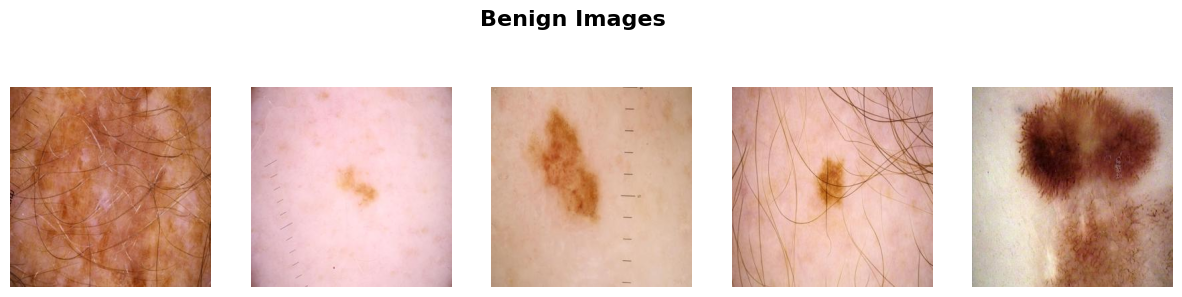

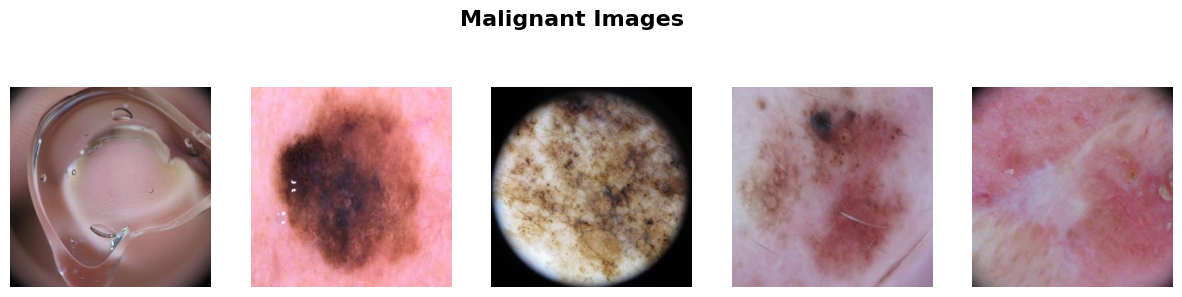

In [ ]:
def show_samples(image_list,title,num_samples = 5):
  plt.figure(figsize =(15,5))
  for i in range(num_samples):
    img = Image.open(image_list[i])
    plt.subplot(1,num_samples,i+1)
    plt.imshow(img)
    plt.axis('off')
  plt.suptitle(title,fontsize=16 ,weight ="bold",y=0.85)
  plt.show()


show_samples(train_benign,'Benign Images',num_samples=5)
show_samples(train_malignant,'Malignant Images',num_samples=5)



# Checking for any duplicate images in both train and test folders of Benign and Malignant classes.

Function for calculating the duplicates in each train and test folders

In [ ]:
def calculate_phash(image_path):
    # Calculate a perceptual hash for an image file
    with Image.open(image_path) as img:
        return imagehash.phash(img)

def find_duplicates(image_list):
    # Find duplicate images in a list based on their perceptual hash values.
    hash_dict = {}
    duplicates = []

    for image_path in image_list:
        image_hash = calculate_phash(image_path)

        if image_hash in hash_dict:
            duplicates.append((image_path, hash_dict[image_hash]))  # Store both the duplicate and original path
        else:
            hash_dict[image_hash] = image_path

    return duplicates

# Find duplicates in each category
train_benign_duplicates = find_duplicates(train_benign)
train_malignant_duplicates = find_duplicates(train_malignant)
test_benign_duplicates = find_duplicates(test_benign)
test_malignant_duplicates = find_duplicates(test_malignant)


In [ ]:
# Print results
print("Train Benign Duplicates:", train_benign_duplicates)
print("Train Malignant Duplicates:", train_malignant_duplicates)
print(" ")
print("Test Benign Duplicates:", test_benign_duplicates)
print("Test Malignant Duplicates:", test_malignant_duplicates)

Train Benign Duplicates: [('/content/melanoma_cancer_dataset/train/benign/melanoma_2907.jpg', '/content/melanoma_cancer_dataset/train/benign/melanoma_297.jpg'), ('/content/melanoma_cancer_dataset/train/benign/melanoma_3040.jpg', '/content/melanoma_cancer_dataset/train/benign/melanoma_1998.jpg'), ('/content/melanoma_cancer_dataset/train/benign/melanoma_655.jpg', '/content/melanoma_cancer_dataset/train/benign/melanoma_4984.jpg'), ('/content/melanoma_cancer_dataset/train/benign/melanoma_1800.jpg', '/content/melanoma_cancer_dataset/train/benign/melanoma_4542.jpg'), ('/content/melanoma_cancer_dataset/train/benign/melanoma_1110.jpg', '/content/melanoma_cancer_dataset/train/benign/melanoma_4197.jpg'), ('/content/melanoma_cancer_dataset/train/benign/melanoma_2703.jpg', '/content/melanoma_cancer_dataset/train/benign/melanoma_2241.jpg'), ('/content/melanoma_cancer_dataset/train/benign/melanoma_3266.jpg', '/content/melanoma_cancer_dataset/train/benign/melanoma_2409.jpg'), ('/content/melanoma_canc

It is observed that there are some duplicate images in train benign,malignant and test benign directories

In [ ]:
# Count of duplicates in each classes for train and test
print("Duplicates count in train dataset")
print(f"Train Benign Duplicates : {len(train_benign_duplicates)}")
print(f"Train Malignant Duplicates : {len(train_malignant_duplicates)}")
print(" ")
print("Duplicates count in test dataset")
print(f"Test Benign Duplicates : {len(test_benign_duplicates)}")
print(f"Test Malignant Duplicates : {len(test_malignant_duplicates)}")

Duplicates count in train dataset
Train Benign Duplicates : 8
Train Malignant Duplicates : 18
 
Duplicates count in test dataset
Test Benign Duplicates : 1
Test Malignant Duplicates : 0


Count of duplicates show that their quantity is very less in dataset

# Image representation of original and duplicate images

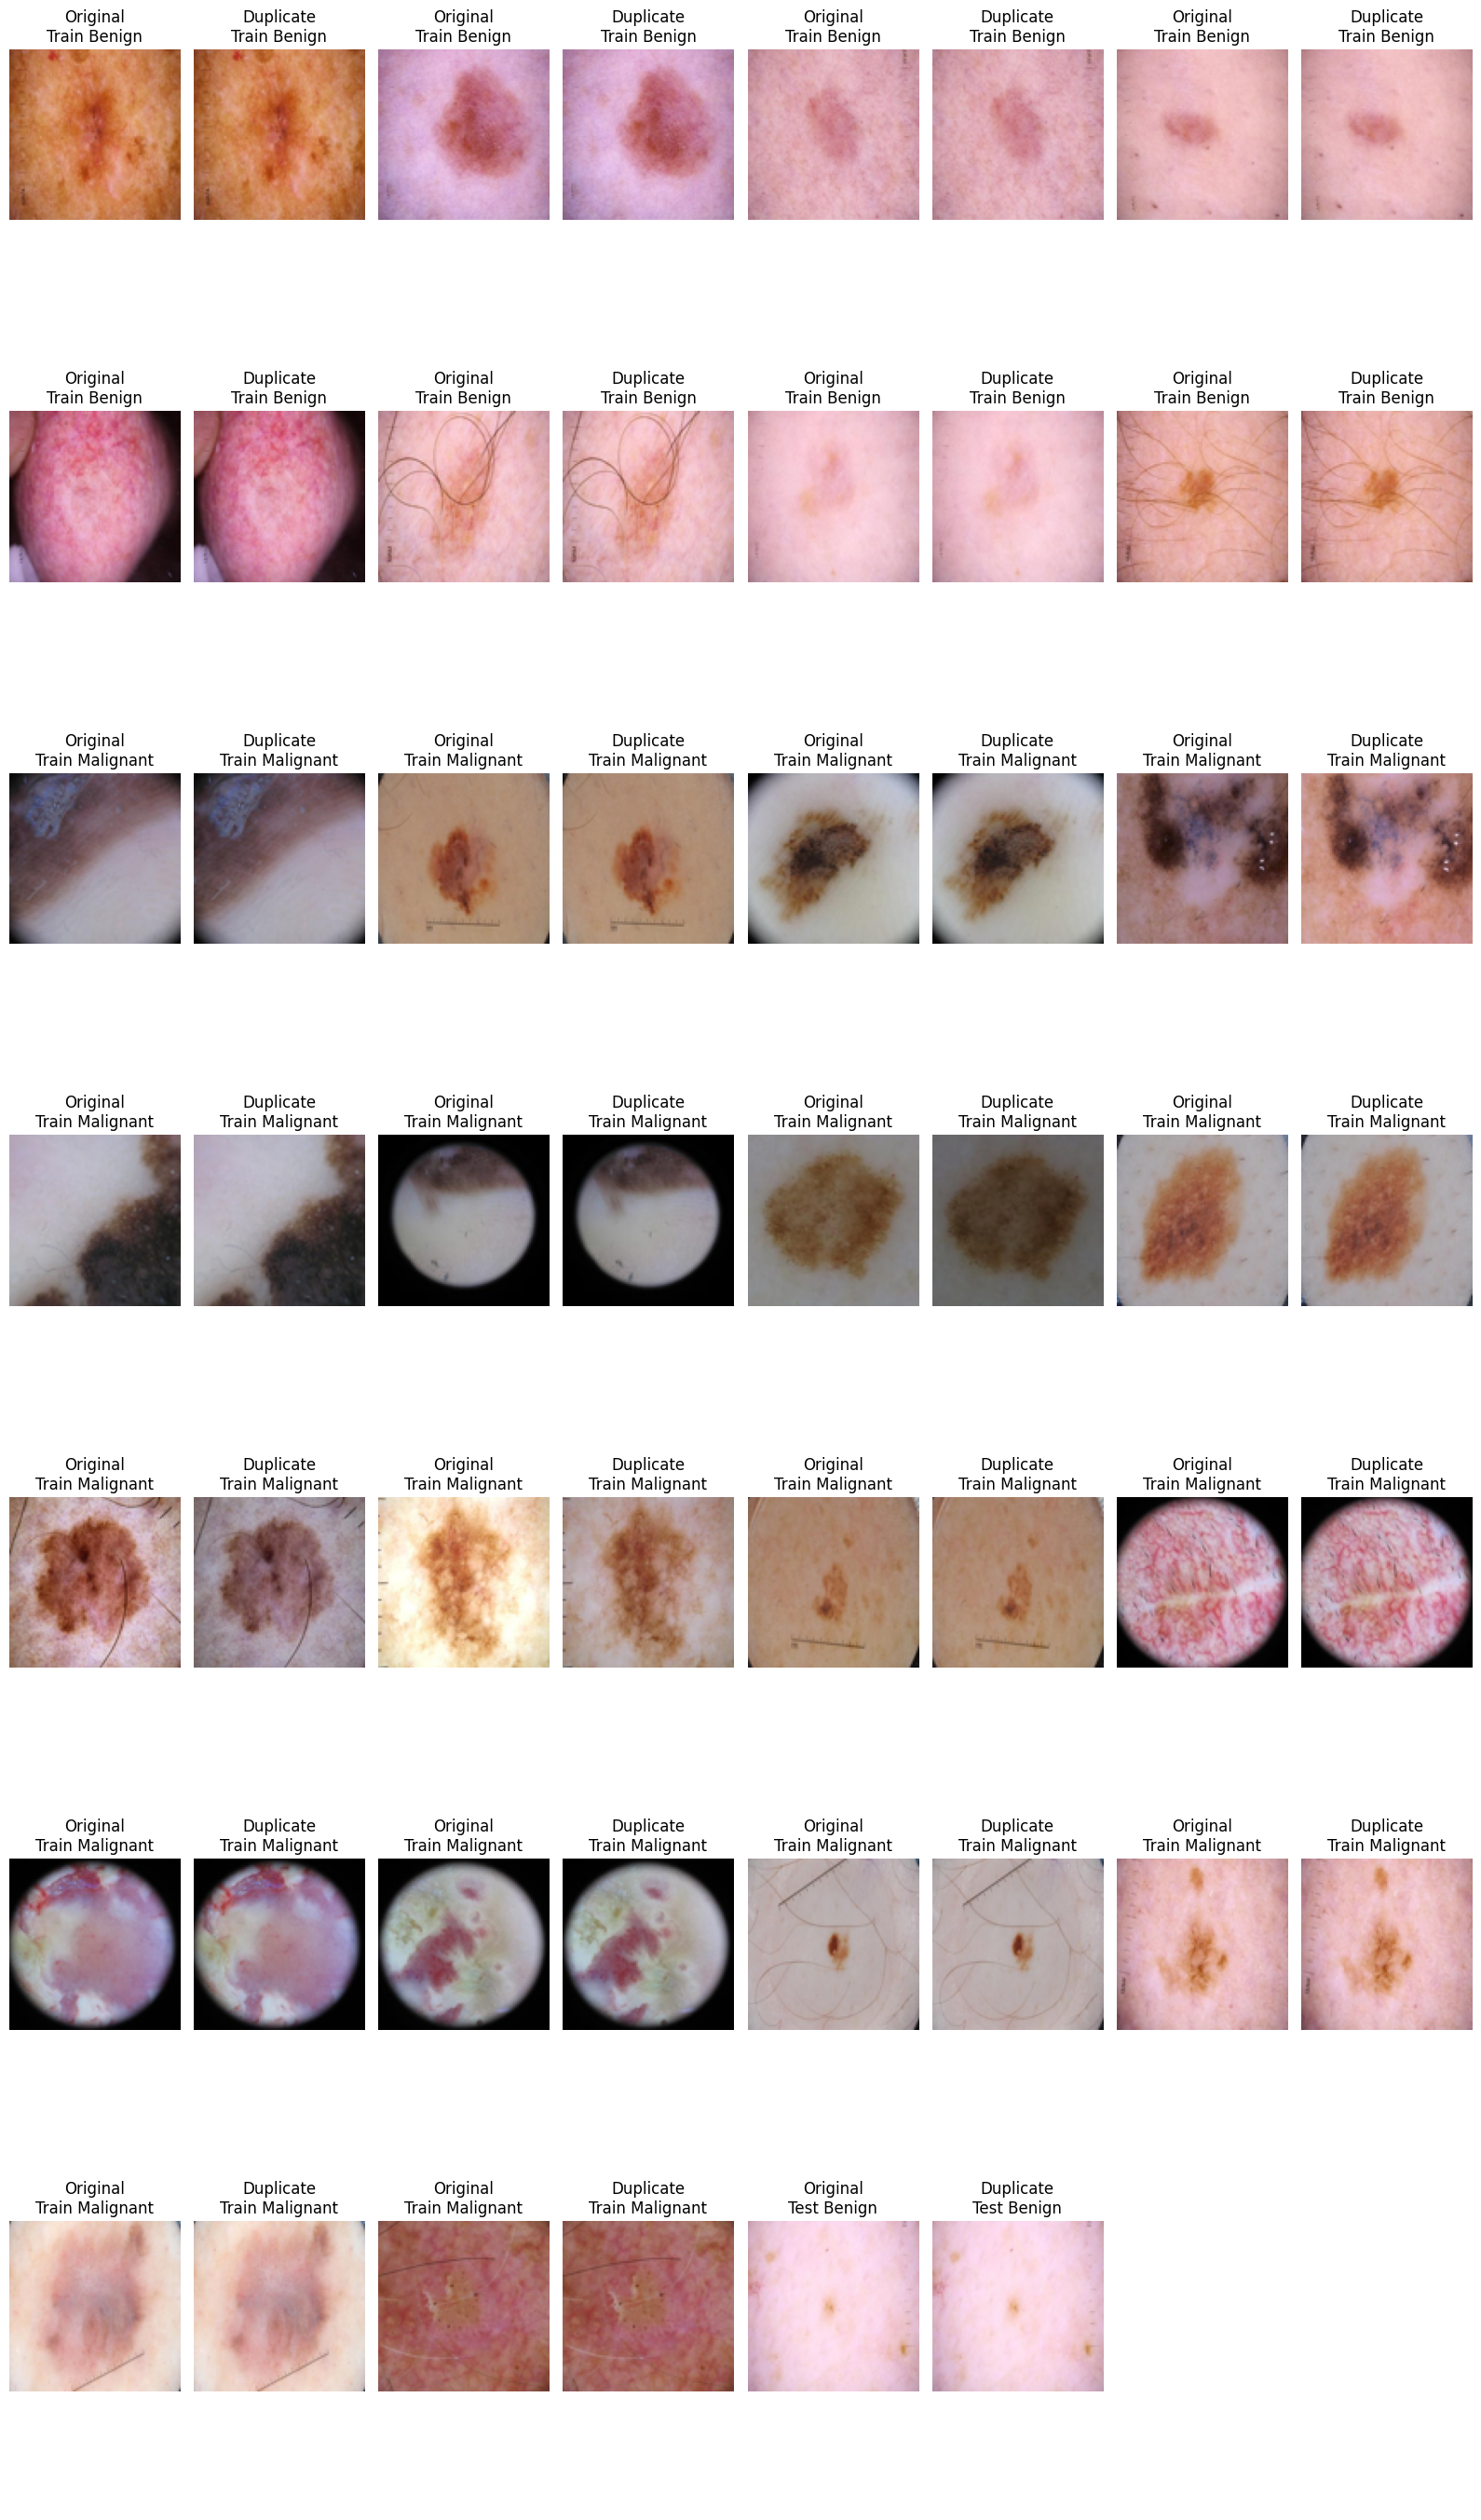

In [ ]:
# Function to convert duplicate lists to DataFrame
def get_duplicate_pairs(duplicates, category):
    # Create a DataFrame for all duplicate pairs
    return pd.DataFrame(duplicates, columns=["Duplicate Image", "Original Image"]).assign(Category=category)

# Create DataFrames for each category
df_train_benign_duplicates = get_duplicate_pairs(train_benign_duplicates, "Train Benign")
df_train_malignant_duplicates = get_duplicate_pairs(train_malignant_duplicates, "Train Malignant")
df_test_benign_duplicates = get_duplicate_pairs(test_benign_duplicates, "Test Benign")
df_test_malignant_duplicates = get_duplicate_pairs(test_malignant_duplicates, "Test Malignant")

# Concatenate all duplicates into one DataFrame
all_duplicates_df = pd.concat([
    df_train_benign_duplicates,
    df_train_malignant_duplicates,
    df_test_benign_duplicates,
    df_test_malignant_duplicates
], ignore_index=True)

# Calculate the number of pairs and grid size
num_pairs = len(all_duplicates_df)
cols = 4  # Set columns to 4 as required
rows = math.ceil(num_pairs / cols)  # Calculate rows based on the number of pairs

fig, axes = plt.subplots(rows, cols * 2, figsize=(16, 4 * rows))  # Each pair has two images (original + duplicate)
axes = axes.flatten()  # Flatten axes array for easier indexing

# Resize each image and plot it
for idx, (row_idx, row) in enumerate(all_duplicates_df.iterrows()):
    original_image = Image.open(row["Original Image"]).resize((100, 100))  # Resize to 100x100
    duplicate_image = Image.open(row["Duplicate Image"]).resize((100, 100))  # Resize to 100x100

    # Plot original image
    axes[idx * 2].imshow(original_image)
    axes[idx * 2].set_title(f"Original\n{row['Category']}")
    axes[idx * 2].axis("off")

    # Plot duplicate image
    axes[idx * 2 + 1].imshow(duplicate_image)
    axes[idx * 2 + 1].set_title(f"Duplicate\n{row['Category']}")
    axes[idx * 2 + 1].axis("off")

# Hide unused subplots, if any
for ax in axes[idx * 2 + 2:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

All the images appear to be similar with respect to the original images

# **Creating new directory without duplicate data**

In [ ]:
# Create new unique directories for benign and malignant images
unique_train_dir = "/content/melanoma_cancer_dataset/train_unique"
unique_test_dir = "/content/melanoma_cancer_dataset/test_unique"

# Create the unique directories
os.makedirs(unique_train_dir + '/benign', exist_ok=True)
os.makedirs(unique_train_dir + '/malignant', exist_ok=True)
os.makedirs(unique_test_dir + '/benign', exist_ok=True)
os.makedirs(unique_test_dir + '/malignant', exist_ok=True)


# Function to find and move unique images

In [ ]:
# Function to find and move unique images from source to target directories based on perceptual hash
def move_unique_images(source_dir, target_dir):
    seen_images = set()

    # Iterate through each category (benign and malignant)
    for category in ['benign', 'malignant']:
        category_source_dir = os.path.join(source_dir, category)
        category_target_dir = os.path.join(target_dir, category)

        # Create target category directory if it does not exist
        os.makedirs(category_target_dir, exist_ok=True)

        # Iterate through all image files in the category subdirectory
        for image_path in glob(os.path.join(category_source_dir, '*')):
            # Open the image and calculate its perceptual hash
            with Image.open(image_path) as img:
                img_hash = imagehash.phash(img)  # Calculate perceptual hash of the image

                # Check if this image has been seen before
                if img_hash not in seen_images:
                    seen_images.add(img_hash)  # Add the unique image's hash to the set
                    shutil.copy(image_path, category_target_dir)  # Copy the image to the target directory

In [ ]:
# Move unique images from train and test directories
move_unique_images(train_dir, unique_train_dir)
move_unique_images(test_dir, unique_test_dir)

print("Moving unique images complete.")

Moving unique images complete.


# Count of images in both test and train for unique benign and malignant images

In [ ]:
#Count of Images in each category
unique_train_benign = glob(unique_train_dir + '/benign/*')
unique_train_malignant = glob(unique_train_dir + '/malignant/*')
unique_test_benign = glob(unique_test_dir + '/benign/*')
unique_test_malignant = glob(unique_test_dir + '/malignant/*')
print(f"Training -  Benign : {len(unique_train_benign)} , Malignant : {len(unique_train_malignant)}")
print(f"Testing -  Benign : {len(unique_test_benign)} , Malignant : {len(unique_test_malignant)}")

Training -  Benign : 4992 , Malignant : 4587
Testing -  Benign : 499 , Malignant : 500


It is observed from count that duplicate images have been removed and unique images have been added to new directories

# **Before removing duplicate images**

# **Distribution of images in training dataset**

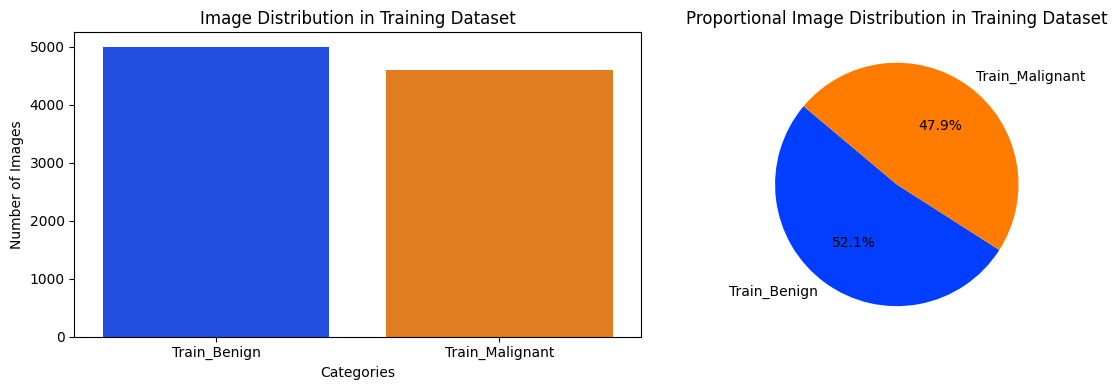

In [ ]:
def plot_image_distribution_train():
    labels = ['Train_Benign', 'Train_Malignant']
    counts = [len(train_benign), len(train_malignant)]

     # Bar plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(x=labels, y=counts, palette='bright' , hue=labels)
    plt.title('Image Distribution in Training Dataset')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')

    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('bright'))
    plt.title('Proportional Image Distribution in Training Dataset')

    plt.tight_layout()
    plt.show()

plot_image_distribution_train()


Train data for Malignant is 4.2% lesser than Benign, thus there is slight imbalance of data between two classes


# Distribution of images in test dataset

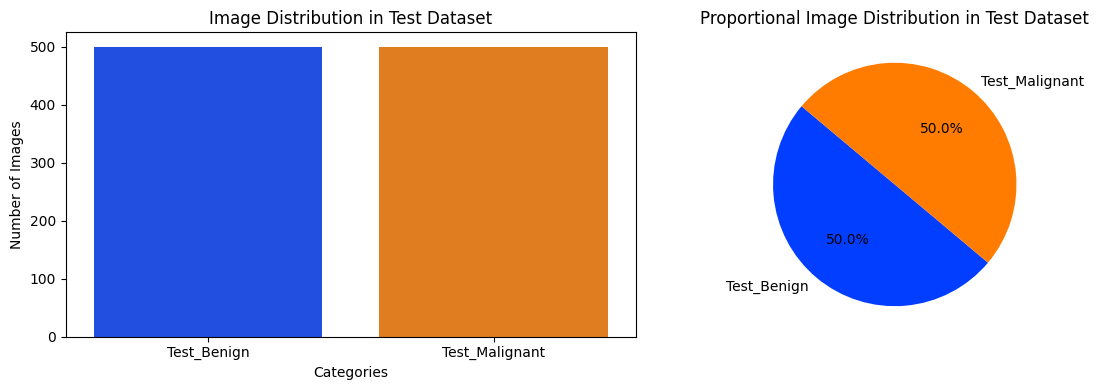

In [ ]:
def plot_image_distribution_test():
    labels = ['Test_Benign', 'Test_Malignant']
    counts = [len(test_benign), len(test_malignant)]

   # Bar plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(x=labels, y=counts, palette='bright' , hue=labels)
    plt.title('Image Distribution in Test Dataset')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')

    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('bright'))
    plt.title('Proportional Image Distribution in Test Dataset')

    plt.tight_layout()
    plt.show()

plot_image_distribution_test()


There is no imbalance in the test dataset between Benign and Malignant

# **After removing the duplicate images**

# Distribution of images in the unique train dataset

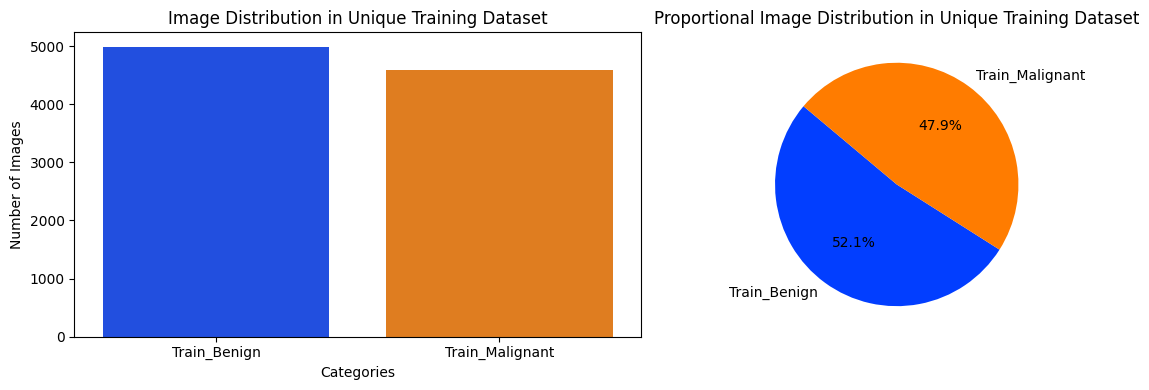

In [ ]:
def plot_image_distribution_train():
    labels = ['Train_Benign', 'Train_Malignant']
    counts = [len(unique_train_benign), len(unique_train_malignant)]

     # Bar plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(x=labels, y=counts, palette='bright' , hue=labels)
    plt.title('Image Distribution in Unique Training Dataset')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')

    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('bright'))
    plt.title('Proportional Image Distribution in Unique Training Dataset')

    plt.tight_layout()
    plt.show()

plot_image_distribution_train()

It can be seen that image distribution has no major effect due to removal of duplicate images

# Distribution of images in the unique test dataset

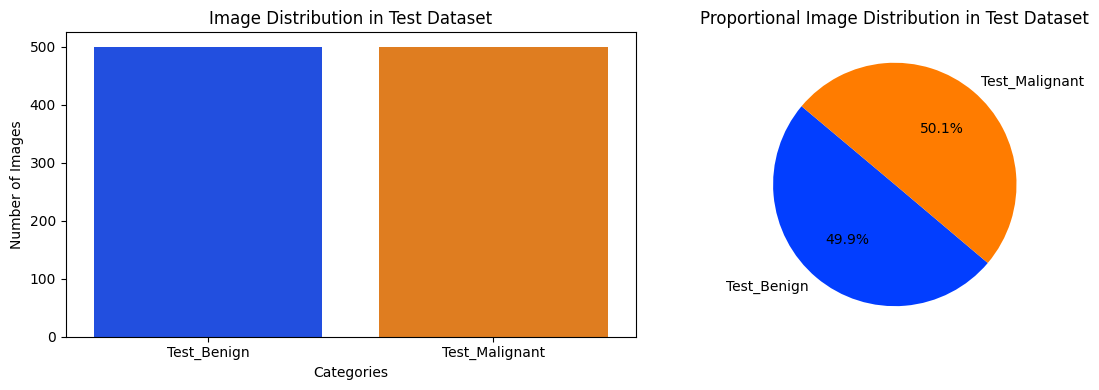

In [ ]:
def plot_image_distribution_test():
    labels = ['Test_Benign', 'Test_Malignant']
    counts = [len(unique_test_benign), len(unique_test_malignant)]

   # Bar plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(x=labels, y=counts, palette='bright' , hue=labels)
    plt.title('Image Distribution in Test Dataset')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')

    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('bright'))
    plt.title('Proportional Image Distribution in Test Dataset')

    plt.tight_layout()
    plt.show()

plot_image_distribution_test()

There is no variation in image distribution after removal of duplicate images

# Image Shape and Size

In [ ]:
def get_image_shapes(image_list, num_samples=3):
    for img_path in image_list[:num_samples]:
        img = Image.open(img_path)
        print(f"Image size (Width x Height): {img.size}")

print("Benign Image Shapes:")
get_image_shapes(unique_train_benign)
print("Malignant Image Shapes:")
get_image_shapes(unique_train_malignant)

Benign Image Shapes:
Image size (Width x Height): (300, 300)
Image size (Width x Height): (300, 300)
Image size (Width x Height): (300, 300)
Malignant Image Shapes:
Image size (Width x Height): (300, 300)
Image size (Width x Height): (300, 300)
Image size (Width x Height): (300, 300)


From the output we can infer that all the images in both dataset are of same shape and size

# Heatmap for the image shape and size in train dataset

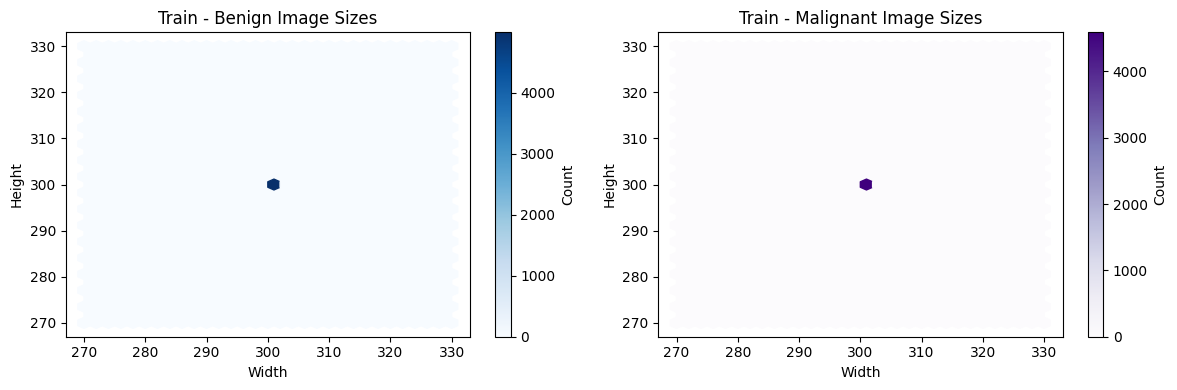

In [ ]:
def plot_image_size_heatmap_train_side_by_side(train_benign_list, train_malignant_list):
    benign_sizes = [Image.open(img).size for img in train_benign_list]
    benign_widths, benign_heights = zip(*benign_sizes)

    malignant_sizes = [Image.open(img).size for img in train_malignant_list]
    malignant_widths, malignant_heights = zip(*malignant_sizes)


    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Benign heatmap
    hexbin1 = axs[0].hexbin(benign_widths, benign_heights, gridsize=30, cmap='Blues')
    axs[0].set_title('Train - Benign Image Sizes')
    axs[0].set_xlabel('Width')
    axs[0].set_ylabel('Height')
    cbar1 = fig.colorbar(hexbin1, ax=axs[0], orientation='vertical')
    cbar1.set_label('Count')

    # Malignant heatmap
    hexbin2 = axs[1].hexbin(malignant_widths, malignant_heights, gridsize=30, cmap='Purples')
    axs[1].set_title('Train - Malignant Image Sizes')
    axs[1].set_xlabel('Width')
    axs[1].set_ylabel('Height')
    cbar2 = fig.colorbar(hexbin2, ax=axs[1], orientation='vertical')
    cbar2.set_label('Count')

    plt.tight_layout()
    plt.show()

plot_image_size_heatmap_train_side_by_side(unique_train_benign, unique_train_malignant)


Since both the classes have same shape and size thus we see similary consistency of heatmap in both the plots

# **Data Preprocessing**
Resizing the images and converting them into arrays for further analysis.
This is essential for feeding it to Neural Network.



*   Machine Learning Models like CNN require input images of same size and format.Real world datasets often have images of different sizes.
*   Normalization makes training faster and better ,with pixel range from 0 to 1 we generally require lesser computational power


*   Raw images are computationally expensive to process and slow down training significantly.






# Normalization of the Images

In [ ]:
def preprocess_images(image_list, target_size=(128, 128)):
    processed_images = []
    for image_path in image_list:
        img = Image.open(image_path)
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized) / 255.0  # Normalizing
        processed_images.append(img_array)

    return np.array(processed_images)

# Preprocessing all training images for both benign and malignant
train_benign_preprocessed = preprocess_images(unique_train_benign)
train_malignant_preprocessed = preprocess_images(unique_train_malignant)

# Preprocessing all test images for both benign and malignant
test_benign_preprocessed = preprocess_images(unique_test_benign)
test_malignant_preprocessed = preprocess_images(unique_test_malignant)

print(f"Train Benign Images Shape: {train_benign_preprocessed.shape}")
print(f"Train Malignant Images Shape: {train_malignant_preprocessed.shape}")
print(f"Test Benign Images Shape: {test_benign_preprocessed.shape}")
print(f"Test Malignant Images Shape: {test_malignant_preprocessed.shape}")


Train Benign Images Shape: (4992, 128, 128, 3)
Train Malignant Images Shape: (4587, 128, 128, 3)
Test Benign Images Shape: (499, 128, 128, 3)
Test Malignant Images Shape: (500, 128, 128, 3)


This code segment takes in images one by one and resizes them to 128 x 128 dimension and normalizes it to range of 0 to 1 by dividing with 255.0

# Pixel Distributions Before v/s After Preprocessing

In [ ]:
def plot_pixel_distribution(image_list, processed_images, title):
    original_img = np.array(Image.open(image_list[0]))  # Original pixel values
    processed_img = processed_images[0]  # Processed pixel values

    plt.figure(figsize=(12, 4))

    # Original pixel distribution
    plt.subplot(1, 2, 1)
    plt.hist(original_img.ravel(), bins=50, color='blue', alpha=0.7)
    plt.title(f'{title} - Original Image Pixel Distribution')
    plt.xlabel('Pixel Intensity (Original)')
    plt.ylabel('Frequency')

    # Processed pixel distribution (after normalization)
    plt.subplot(1, 2, 2)
    plt.hist(processed_img.ravel(), bins=50, color='green', alpha=0.7)
    plt.title(f'{title} - Processed Image Pixel Distribution')
    plt.xlabel('Pixel Intensity (Normalized)')
    plt.ylabel('Frequency')

    plt.show()

# Pixel intensity distribution for Benign

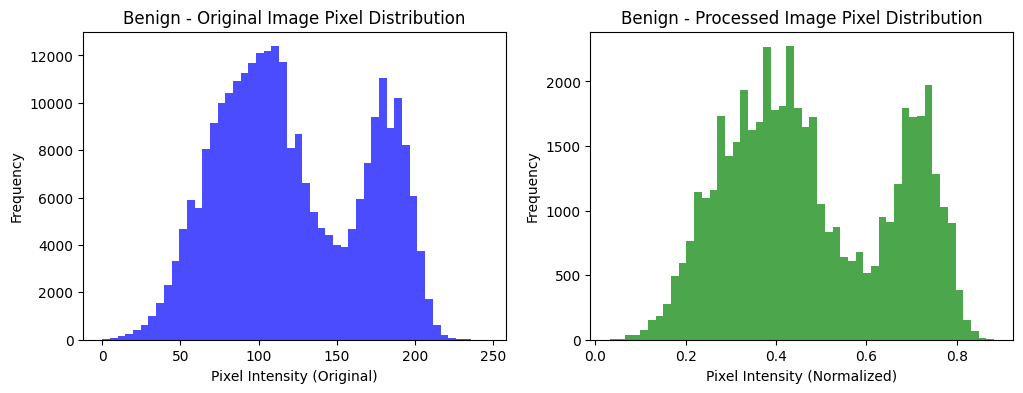

In [ ]:
# Pixel distribution for a benign image
plot_pixel_distribution(unique_train_benign, train_benign_preprocessed, 'Benign')

Overall frequency of pixels remains almost similar even after normalization

# Pixel intensity distribution for Malignant

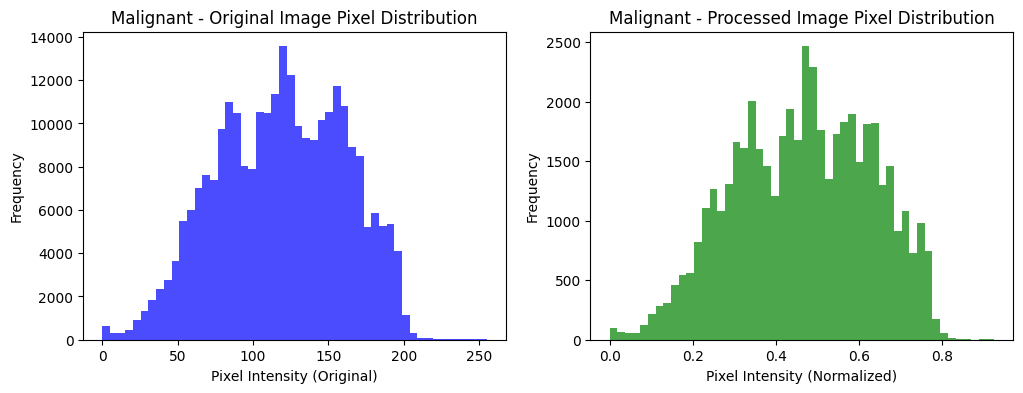

In [ ]:
# Pixel distribution for a malignant image
plot_pixel_distribution(unique_train_malignant, train_malignant_preprocessed, 'Malignant')

Overall frequency of pixels remains almost similar even after normalization

# **Comparison of Original and Normalized Images**

In [ ]:
def plot_image_grid(image_list, processed_images, title):
    n = min(2, len(image_list))
    plt.figure(figsize=(12, 6))

    for i in range(n):
        # Original Image
        plt.subplot(n, 2, 2*i + 1)
        img = Image.open(image_list[i])
        plt.imshow(img)
        plt.title(f'Original Image {i + 1}')
        plt.axis('off')

        # Processed Image
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(processed_images[i])
        plt.title(f'Processed Image {i + 1}')
        plt.axis('off')

    plt.suptitle(f'{title} - Original v/s Processed Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Comparison of Original v/s Processed for Benign

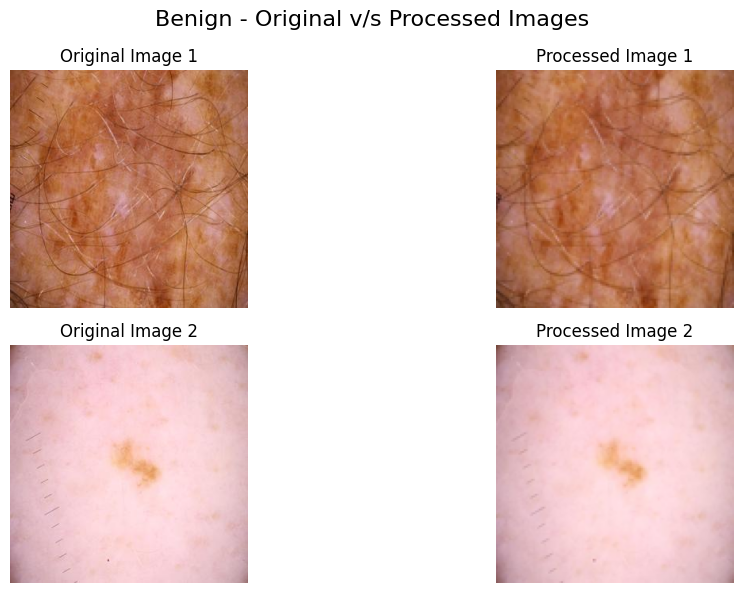

In [ ]:
plot_image_grid(unique_train_benign, train_benign_preprocessed, 'Benign')


After normalization the colors appear more standardized and balanced

# Comparison of Original v/s Processed for Malignant

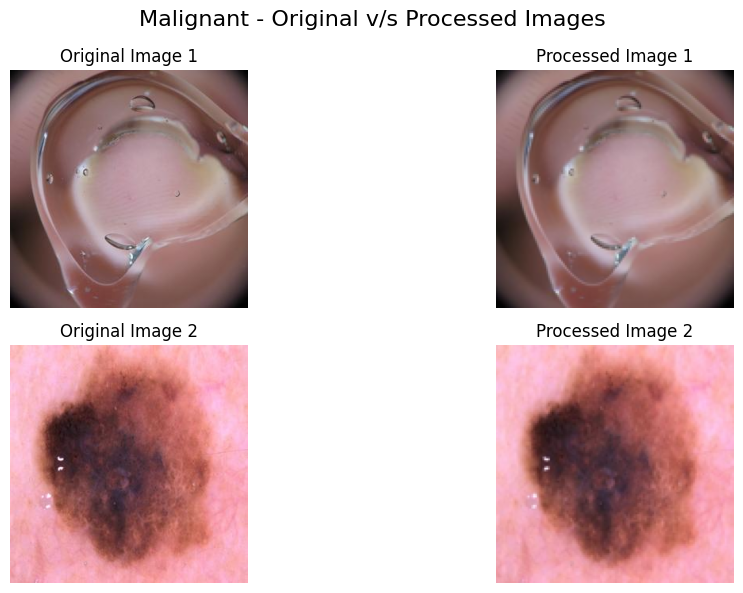

In [ ]:
plot_image_grid(unique_train_malignant, train_malignant_preprocessed, 'Malignant')

Normalized images have overall brightness better than the original images

# HeatMap Distribution for Original v/s Normalized Image

In [ ]:
def plot_heatmap_pixel_distribution(image_list, processed_images, title):
    # Original image
    original_img = np.array(Image.open(image_list[0]))
    processed_img = processed_images[0]

    plt.figure(figsize=(16, 6))

    # Heatmap for Original
    plt.subplot(1, 2, 1)
    sns.heatmap(original_img[:, :, 0], cmap='Blues', cbar=False)
    plt.title(f'{title} - Original Image Heatmap')
    plt.axis('off')

    # Heatmap for Processed
    plt.subplot(1, 2, 2)
    sns.heatmap(processed_img[:, :, 0], cmap='Blues', cbar=False)
    plt.title(f'{title} - Processed Image Heatmap')
    plt.axis('off')

    plt.show()


# Heatmap distribution of Benign

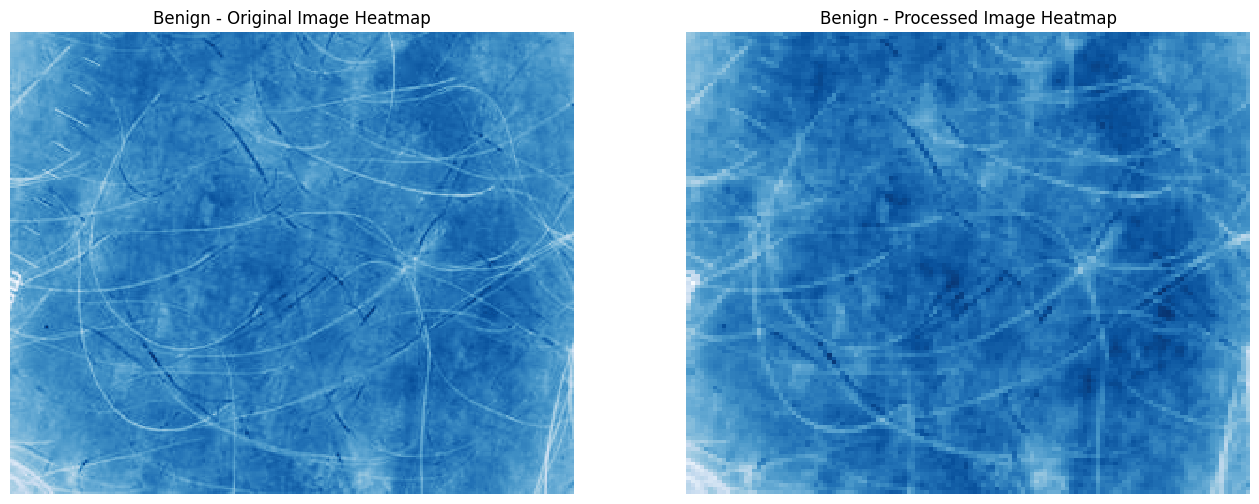

In [ ]:
# Plot heatmap for a sample benign image
plot_heatmap_pixel_distribution(unique_train_benign, train_benign_preprocessed, 'Benign')

Original heatmap has some regions that are extremely bright (high values) while others are very dark (low values). In the normalized heatmap, these extremes are less noticeable, and the values cover a broader range more evenly.

# Heatmap distribution of Malignant

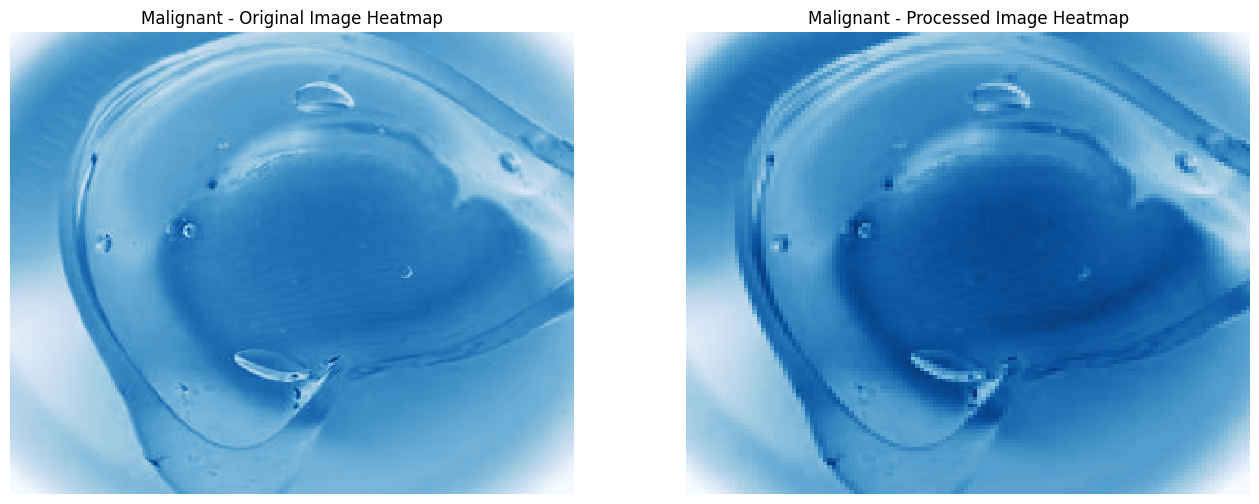

In [ ]:
# Plot heatmap for a sample Malignant image
plot_heatmap_pixel_distribution(unique_train_malignant, train_malignant_preprocessed, 'Malignant')

The dominance of certain colors like whites and darker regions have been standardized and are uniform in processed image

# **Grayscale v/s Original image comparison for train dataset**

# Utility functions for conversion from RGB to Grayscale

In [ ]:
# Function to grayscale all normalized images
def create_preprocessed_grayscale_images(image_list):
    img_grayscaled = []
    for img in image_list:
        if img.shape[-1] == 3:  # Checking if the image is in RGB format
            img_gray = np.mean(img, axis=-1)  # Average of 3 channels to single grayscale channel
            img_grayscaled.append(img_gray)
        else:
            img_grayscaled.append(img)  # If image already grayscale
    return np.array(img_grayscaled)

# Function to convert RGB image to grayscale
def convert_to_grayscale(image_path):
    img = Image.open(image_path)
    img_grayscale = img.convert('L')   # Conversion to grayscale
    return np.array(img), np.array(img_grayscale)

# Function to plot the images
def plot_images(original_img, grayscale_img, title):
    plt.figure(figsize=(12,6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f'{title} Image')
    plt.axis('off')

    # Grayscale image
    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title(f'{title} - Grayscale Image')
    plt.axis('off')

    plt.show()

# Calculates the statistical values for comparison
def calculate_statistics(img):
    mean_val = np.mean(img)
    std_val = np.std(img)
    return mean_val, std_val

# Function to plot comparison Historgram
def plot_histograms(original_img, grayscale_img, title):
    original_img_gray = np.mean(original_img, axis=2)  # Convert original to grayscale for comparison

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(original_img_gray.ravel(), bins=256, color='blue', alpha=0.5, label='Original')
    plt.title(f'{title} - Histogram')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.hist(grayscale_img.ravel(), bins=256, color='gray', alpha=0.5, label='Grayscale')
    plt.title(f'{title} - Grayscale Histogram')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


# Converting original train dataset into grayscale for both Benign and Malignant

In [ ]:
train_original_benign,train_benign_grayscale = convert_to_grayscale(unique_train_benign[0])
train_original_malignant,train_malignant_grayscale = convert_to_grayscale(unique_train_malignant[0])


# Converting preprocessed train dataset into grayscale for both Benign and Malignant

In [ ]:
# Grayscale conversion for Benign and Malignant
preprocessed_train_benign_grayscale = create_preprocessed_grayscale_images(train_benign_preprocessed)
preprocessed_train_malignant_grayscale = create_preprocessed_grayscale_images(train_malignant_preprocessed)

In [ ]:
# Printing shape and size of the preprocessed grayscaled bening and malignant arrays
print(f"Preprocessed Train Benign Grayscale Images Shape: {preprocessed_train_benign_grayscale.shape}")
print(f"Preprocessed Train Malignant Grayscale Images Shape: {preprocessed_train_malignant_grayscale.shape}")

Preprocessed Train Benign Grayscale Images Shape: (4992, 128, 128)
Preprocessed Train Malignant Grayscale Images Shape: (4587, 128, 128)


# Storing normalized grayscaled images in separate folder

In [ ]:
# Function to create the directories if they do not exist
def create_directories(base_dir):
    os.makedirs(base_dir, exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'train', 'benign'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'train', 'malignant'), exist_ok=True)

# Path to save the dataset
base_dir = 'normalized_grayscale_dataset'

# Create the necessary directories
create_directories(base_dir)

# Save benign images
for i, image in enumerate(preprocessed_train_benign_grayscale):
    # Add channel dimension to grayscale images (shape: (128, 128, 1))
    image_with_channel = np.expand_dims(image, axis=-1)

    # Create the full path for the image to be saved
    image_path = os.path.join(base_dir, 'train', 'benign', f"benign_{i}.png")

    # Save the image
    save_img(image_path, image_with_channel)

# Save malignant images
for i, image in enumerate(preprocessed_train_malignant_grayscale):
    # Add channel dimension to grayscale images (shape: (128, 128, 1))
    image_with_channel = np.expand_dims(image, axis=-1)

    # Create the full path for the image to be saved
    image_path = os.path.join(base_dir, 'train', 'malignant', f"malignant_{i}.png")

    # Save the image
    save_img(image_path, image_with_channel)

print("Images have been saved successfully!")

Images have been saved successfully!


# Grayscale comparison for Benign

In [ ]:
# Load and process benign image
preprocessed_benign = train_benign_preprocessed[0]
preprocessed_benign_grayscale = preprocessed_train_benign_grayscale[0]

print("Benign Image Statistics:")
preprocessed_benign_mean, preprocessed_benign_std = calculate_statistics(preprocessed_benign.mean(axis=2))
preprocessed_benign_grayscale_mean, preprocessed_benign_grayscale_std = calculate_statistics(preprocessed_benign_grayscale)
print(f'Original Mean: {preprocessed_benign_mean:.4f}, Original Std Dev: {preprocessed_benign_std:.4f}')
print(f'Grayscale Mean: {preprocessed_benign_grayscale_mean:.4f}, Grayscale Std Dev: {preprocessed_benign_grayscale_std:.4f}\n')


Benign Image Statistics:
Original Mean: 0.4782, Original Std Dev: 0.0732
Grayscale Mean: 0.4782, Grayscale Std Dev: 0.0732



->**Mean value represents the average pixel intensity of the image**

->**Standard deviation measures the amount of variation or dispersion in the pixel intensity values**

*   Mean values of original and grayscale are very close suggesting that overall brightness is preserved but grayscales higher mean suggest it is marginally brighter than original RGB.
*   Standard deviation differ marginally suggesting variation in pixel intensities is preserved.



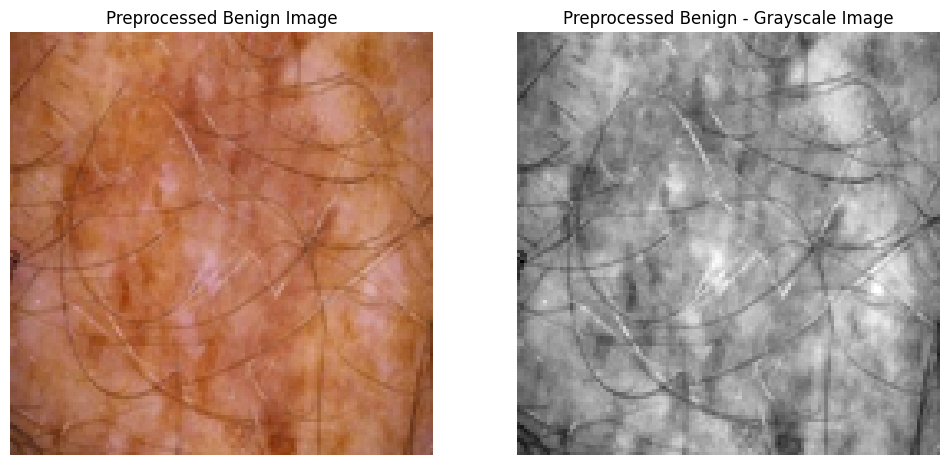

In [ ]:
# Plot images
plot_images(preprocessed_benign, preprocessed_benign_grayscale, 'Preprocessed Benign')

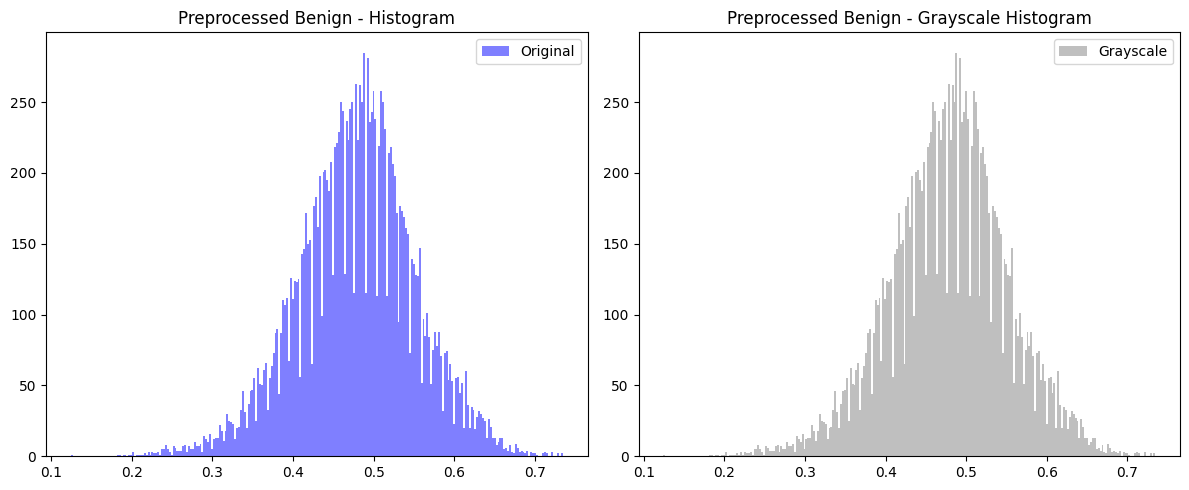

In [ ]:
# Plot histograms
plot_histograms(preprocessed_benign, preprocessed_benign_grayscale, 'Preprocessed Benign')

Shape of histogram for grayscale is little different due to averaging process

-> The "averaging process" during the conversion from an RGB image to a grayscale image typically refers to the method of combining the three color channels (red, green, and blue) into a single intensity value.

-> This process is often done using a weighted sum to better represent human perception of brightness.


# Grayscale comparison for Malignant

In [ ]:
# Load and process malignant image
preprocessed_malignant = train_malignant_preprocessed[0]
preprocessed_malignant_grayscale = preprocessed_train_malignant_grayscale[0]

print("Malignant Image Statistics:")
malignant_original_mean, malignant_original_std = calculate_statistics(preprocessed_malignant.mean(axis=2))
malignant_grayscale_mean, malignant_grayscale_std = calculate_statistics(preprocessed_malignant_grayscale)
print(f'Original Mean: {malignant_original_mean:.4f}, Original Std Dev: {malignant_original_std:.4f}')
print(f'Grayscale Mean: {malignant_grayscale_mean:.4f}, Grayscale Std Dev: {malignant_grayscale_std:.4f}\n')


Malignant Image Statistics:
Original Mean: 0.4661, Original Std Dev: 0.1529
Grayscale Mean: 0.4661, Grayscale Std Dev: 0.1529



Mean and standard deviation for both original and grayscale images are almost similar suggesting overall brightness and variation of pixels are preserved

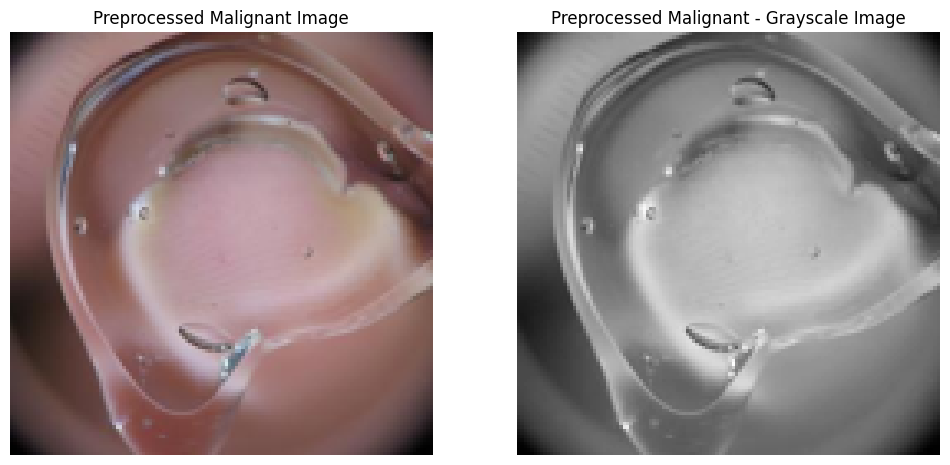

In [ ]:
# Plot images
plot_images(preprocessed_malignant,preprocessed_malignant_grayscale,'Preprocessed Malignant')

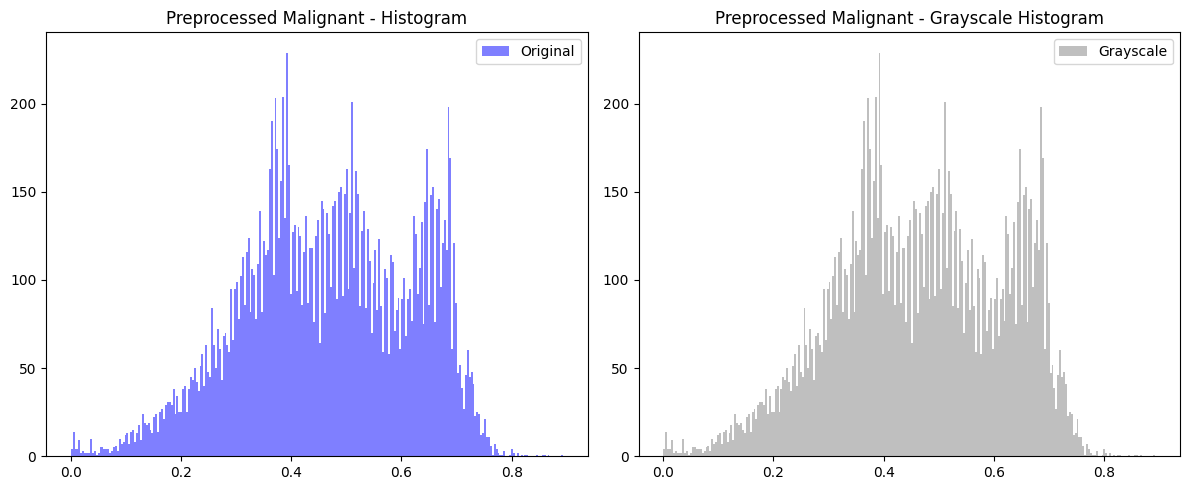

In [ ]:
# Plot Histograms
plot_histograms(preprocessed_malignant, preprocessed_malignant_grayscale, 'Preprocessed Malignant')

# **Data Augmentation**


*   Data augmentation helps in handling small image datasets
*   Augmentation by doing rotation , flipping and zooming helps increase the number of training samples

*  Helps in generalization of the model to perform better with any new input
*  Prevents Overfitting





# Directory to store the augmented images (Preprocessed grayscale)

In [ ]:
# Directory to save the augmented images
augmented_benign_dir = '/content/augmented_melanoma_cancer_dataset/train/benign'
augmented_malignant_dir = '/content/augmented_melanoma_cancer_dataset/train/malignant'
os.makedirs(augmented_benign_dir, exist_ok=True)
os.makedirs(augmented_malignant_dir, exist_ok=True)

# Performing data augmentation on the preprocessed grayscale images for both Benign and Malignant classes

In [ ]:
# Initialize ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0   # Black color for grayscale , preferable to stick with black filling to avoid introducing unnecessary artifacts around lesions or skin features.
)


# Function to batch augment and save images with counts
def batch_augment_images(images, save_dir, label_prefix, batch_size=100, augmentations=5):
    original_count = len(images)
    augmented_count = 0

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Process in batches
    for batch_start in range(0, original_count, batch_size):
        batch_end = min(batch_start + batch_size, original_count)
        batch_images = images[batch_start:batch_end]

        for idx, img in enumerate(batch_images):
            try:
                # Prepare each image for augmentation by expanding dimensions to include the channel
                img = np.expand_dims(img, axis=-1)  # Shape becomes (128, 128, 1)
                img = np.expand_dims(img, axis=0)    # Shape becomes (1, 128, 128, 1) for flow

                # Generate and save augmented images
                i = 0
                for batch in datagen.flow(img, batch_size=1, save_to_dir=save_dir,
                                          save_prefix=f"{label_prefix}_{batch_start + idx}", save_format='jpg'):
                    i += 1
                    augmented_count += 1
                    if i >= augmentations:
                        break

            except Exception as e:
                print(f"Error processing image {label_prefix}_{batch_start + idx}: {e}")

    return original_count, augmented_count


# Function to batch augment and save images with counts
def batch_augment_orig_images(images, save_dir, label_prefix, batch_size=100, augmentations=5):
    original_count = len(images)
    augmented_count = 0

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Process in batches
    for batch_start in range(0, original_count, batch_size):
        batch_end = min(batch_start + batch_size, original_count)
        batch_images = images[batch_start:batch_end]

        for idx, img in enumerate(batch_images):
            try:
                # Prepare each image for augmentation by expanding only the batch dimension
                img = np.expand_dims(img, axis=0)  # Shape becomes (1, 128, 128, 3)

                # Generate and save augmented images
                i = 0
                for batch in datagen.flow(img, batch_size=1, save_to_dir=save_dir,
                                          save_prefix=f"{label_prefix}_{batch_start + idx}", save_format='jpg'):
                    i += 1
                    augmented_count += 1
                    if i >= augmentations:
                        break

            except Exception as e:
                print(f"Error processing image {label_prefix}_{batch_start + idx}: {e}")

    return original_count, augmented_count


# Apply batch augmentation to each preprocessed grayscale image set and store counts
benign_original_count, benign_augmented_count = batch_augment_images(preprocessed_train_benign_grayscale, augmented_benign_dir, label_prefix='benign')
malignant_original_count, malignant_augmented_count = batch_augment_images(preprocessed_train_malignant_grayscale, augmented_malignant_dir, label_prefix='malignant')


# Print counts
print(f"Benign - Original Images: {benign_original_count}, Augmented Images: {benign_augmented_count}")
print(f"Malignant - Original Images: {malignant_original_count}, Augmented Images: {malignant_augmented_count}")

print("Batch augmentation complete. Augmented images saved to specified directories.")


Benign - Original Images: 4992, Augmented Images: 24960
Malignant - Original Images: 4587, Augmented Images: 22935
Batch augmentation complete. Augmented images saved to specified directories.


Amount of augmented images created are 5 for each image in preprocessed grayscale dataset

# **Exploratory data analysis of augmented dataset**

# Loading augmented images dataset

In [ ]:
print(f'Number of images in the augmented benign directory: {len(os.listdir(augmented_benign_dir))}')
print(f'Number of images in the augmented malignant directory: {len(os.listdir(augmented_malignant_dir))}')

Number of images in the augmented benign directory: 24951
Number of images in the augmented malignant directory: 22931


As analyzed from the real count of augmented images in both classes, it is seen that both benign and malignant classes loose negligible amount of newly created images during augmentation.

# Image distribution in augmented dataset

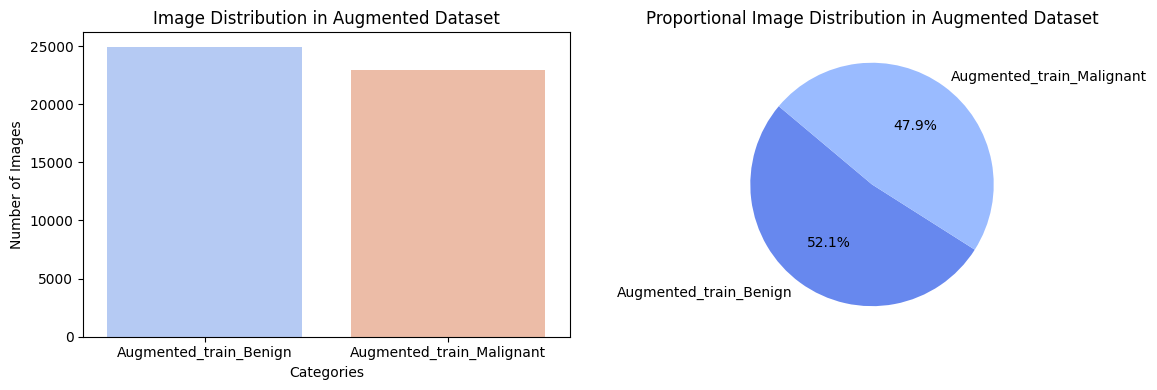

In [ ]:
# Function to plot the image distribution
def plot_image_distribution_test():
    labels = ['Augmented_train_Benign', 'Augmented_train_Malignant']
    counts = [len(os.listdir(augmented_benign_dir)), len(os.listdir(augmented_malignant_dir))]

   # Bar plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(x=labels, y=counts, palette='coolwarm' , hue=labels)
    plt.title('Image Distribution in Augmented Dataset')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')

    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('coolwarm'))
    plt.title('Proportional Image Distribution in Augmented Dataset')

    plt.tight_layout()
    plt.show()

plot_image_distribution_test()

It can be observed that image distribution remains almost similar even after data augmentation.

In [ ]:
# Loading the image data into variables
# Benign
original_rgb_benign = Image.open(train_benign[0])
original_rgb_ben = np.array(original_rgb_benign)
original_grayscale_benign = train_benign_grayscale
augmented_benign = os.listdir(augmented_benign_dir)

# Malignant
original_rgb_malignant = Image.open(train_malignant[0])
original_rgb_malig = np.array(original_rgb_malignant)
original_grayscale_malignant = train_malignant_grayscale
augmented_malignant = os.listdir(augmented_malignant_dir)



# Comparison between original RGB , original grayscale and augmented images of benign

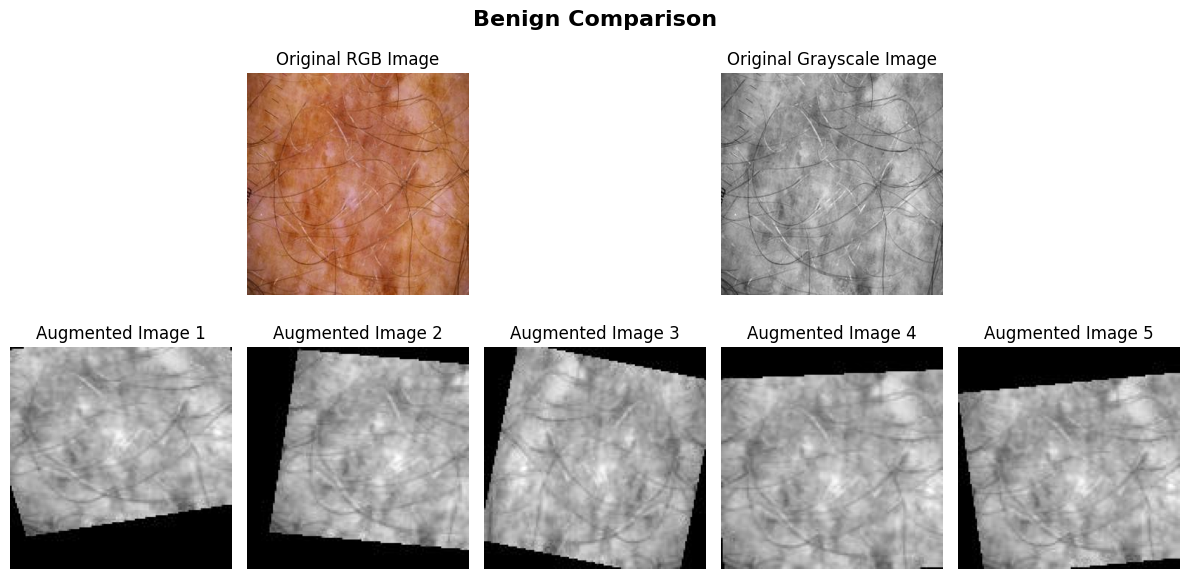

In [ ]:
# Plotting the comparison
plt.figure(figsize=(12, 6))
plt.suptitle("Benign Comparison",fontsize=16 ,weight ="bold",y=0.99)
# Original RGB image
plt.subplot(2, 5, 2)
plt.imshow(original_rgb_ben)
plt.title('Original RGB Image')
plt.axis('off')

# Original Grayscale image
plt.subplot(2, 5, 4)
plt.imshow(original_grayscale_benign, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

# Augmented images
num_augmented_to_show = 5
# Filter images that start with 'benign_0_0_' in their name
filtered_augmented_benign = [img for img in augmented_benign if img.startswith('benign_0_0_')]

for idx in range(min(num_augmented_to_show, len(augmented_benign))):
    plt.subplot(2, 5, idx + 6)
    aug_img = Image.open(os.path.join(augmented_benign_dir, filtered_augmented_benign[idx]))
    aug_img = np.array(aug_img)  # Convert to NumPy array
    plt.imshow(aug_img, cmap="gray")
    plt.title(f'Augmented Image {idx + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

5 augmented images can be seen that are formed using preprocessed grayscale images by applying various paramters like rotation, width_shift,shear etc.

# Comparison between original RGB , original grayscale and augmented images of malignant

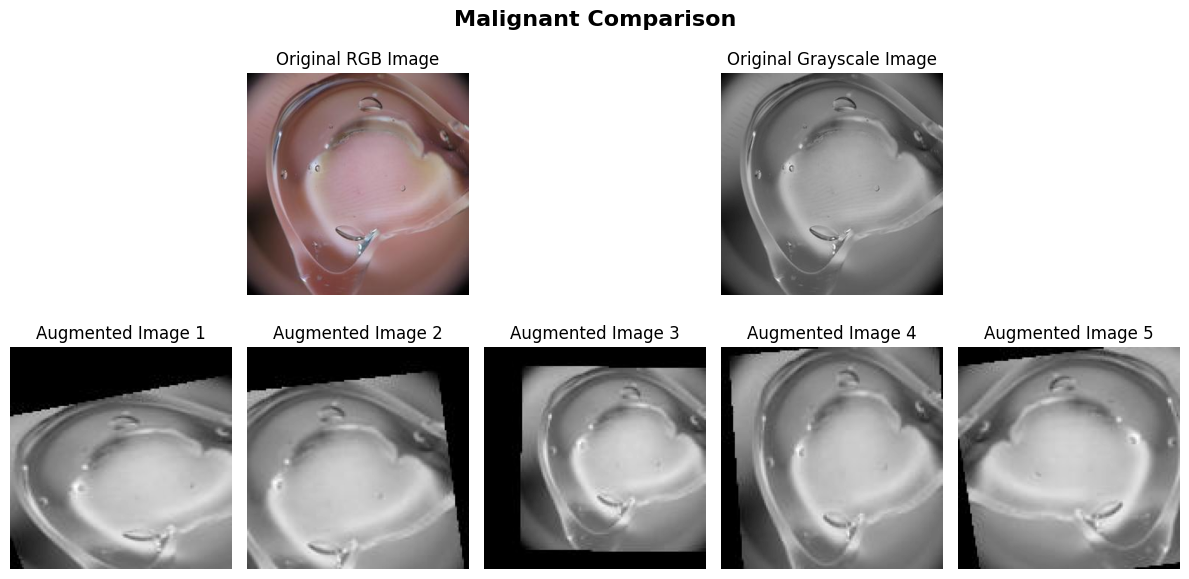

In [ ]:
# Plotting the comparison
plt.figure(figsize=(12, 6))
plt.suptitle("Malignant Comparison",fontsize=16 ,weight ="bold",y=0.99)
# Original RGB image
plt.subplot(2, 5, 2)
plt.imshow(original_rgb_malig)
plt.title('Original RGB Image')
plt.axis('off')

# Original Grayscale image
plt.subplot(2, 5, 4)
plt.imshow(original_grayscale_malignant, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

# Augmented images
num_augmented_to_show = 5
# Filter images that start with 'benign_0_0_' in their name
filtered_augmented_malignant = [img for img in augmented_malignant if img.startswith('malignant_0_0_')]

for idx in range(min(num_augmented_to_show, len(augmented_malignant))):
    plt.subplot(2, 5, idx + 6)
    aug_img = Image.open(os.path.join(augmented_malignant_dir, filtered_augmented_malignant[idx]))
    aug_img = np.array(aug_img)  # Convert to NumPy array
    plt.imshow(aug_img, cmap="gray")
    plt.title(f'Augmented Image {idx + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

-> It is observed that augmented images have black portions , it is to fill in the space created due to different parameters that have been applied on image.

-> It is better to fill the nearest empty space with constant colors for our model as it will create less confusion and our model will be able to learn well.

# Directory to store the augmented dataset for preprocessed RGB

In [ ]:
# Directory to save the augmented images
orig_augmented_benign_dir = '/content/original_augmented_melanoma_cancer_dataset/train/benign'
orig_augmented_malignant_dir = '/content/original_augmented_melanoma_cancer_dataset/train/malignant'
os.makedirs(orig_augmented_benign_dir, exist_ok=True)
os.makedirs(orig_augmented_malignant_dir, exist_ok=True)

# Augmenting the preprocessed RGB dataset

In [ ]:
# Call the batch augmentation on the preprocessed datasets
benign_original_count, benign_augmented_count = batch_augment_orig_images(train_benign_preprocessed, orig_augmented_benign_dir, label_prefix='benign')
malignant_original_count, malignant_augmented_count = batch_augment_orig_images(train_malignant_preprocessed, orig_augmented_malignant_dir, label_prefix='malignant')

# Print counts
print(f"Benign - Original Images: {benign_original_count}, Augmented Images: {benign_augmented_count}")
print(f"Malignant - Original Images: {malignant_original_count}, Augmented Images: {malignant_augmented_count}")

print("Batch augmentation complete. Augmented images saved to specified directories.")



Benign - Original Images: 4992, Augmented Images: 24960
Malignant - Original Images: 4587, Augmented Images: 22935
Batch augmentation complete. Augmented images saved to specified directories.


In [ ]:
print(f'Number of images in the original augmented benign directory: {len(os.listdir(orig_augmented_benign_dir))}')
print(f'Number of images in the original augmented malignant directory: {len(os.listdir(orig_augmented_malignant_dir))}')

Number of images in the original augmented benign directory: 24953
Number of images in the original augmented malignant directory: 22929




----------------------------------------------------------------------------------------------------------------------------------------------------------------



# **Model Development**

# **1.Basic model based on original dataset**

In [3]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc,ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import math


# Loading and preprocessing the images from train and test dataset

In [ ]:
#Generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/melanoma_cancer_dataset/train_unique',
    labels="inferred",                              # Automatically infer labels based on folder names
    label_mode="int",                               # Encode labels as integers (0 and 1 for binary classification)
    color_mode="rgb",                               # Load images in RGB format
    batch_size=32,                                  # Number of images per batch
    image_size=(150,150)                           # Resize images to 256x256 pixels
).repeat()


validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/melanoma_cancer_dataset/test_unique',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(150,150)
).repeat()

# Create a non-repeating validation dataset for evaluation and prediction
validation_ds_eval = keras.utils.image_dataset_from_directory(
    directory='/content/melanoma_cancer_dataset/test_unique',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(150,150),
    shuffle=False  # Keeps order consistent
)

Found 9579 files belonging to 2 classes.
Found 999 files belonging to 2 classes.
Found 999 files belonging to 2 classes.


This code snippet uses TensorFlow's keras.utils.image_dataset_from_directory function to load and preprocess images from training and test directories.

In [ ]:
num_train_images = 9579
num_val_images = 999
batch_size = 32

steps_per_epoch = math.ceil(num_train_images / batch_size)
validation_steps = math.ceil(num_val_images / batch_size)

# CNN model creation with 3 layers

In [ ]:
# Initialize the Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Third Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output to feed into fully connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- **Conv2D layers:** Extract features using filters; the number of filters increases to capture more complex patterns.
- **MaxPooling2D layers:** Downsample the feature maps, reducing computation and focusing on key features.
- **Flatten:** Prepares data for the Dense layers by converting 2D matrices into a 1D vector.
- **Dense layers:** Perform classification based on learned features, with the final layer using a sigmoid for binary output.

# Model Summary

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      37,880,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,251,649 (145.92 MB)

 Trainable params: 38,251,649 (145.92 MB)

 Non-trainable params: 0 (0.00 B)

- Total params: The total number of trainable parameters in the model is 14,847,297. These are the values the model will learn during training.
- Trainable params: All parameters are trainable in this model (no frozen layers).

# Training Model

In [ ]:
# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.1),loss='binary_crossentropy',metrics=['accuracy'])

This setup will prepare the model to train using the Adam optimizer, optimizing for binary classification with cross-entropy loss, and will monitor accuracy as a measure of performance.

In [ ]:
history = model.fit(train_ds,steps_per_epoch=steps_per_epoch,epochs=10,validation_data=validation_ds,validation_steps=validation_steps)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.5356 - loss: 96639320.0000 - val_accuracy: 0.4995 - val_loss: 0.7017
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.5052 - loss: 0.6947 - val_accuracy: 0.4995 - val_loss: 0.6948
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5026 - loss: 0.6945 - val_accuracy: 0.4995 - val_loss: 0.6959
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5027 - loss: 0.6953 - val_accuracy: 0.4995 - val_loss: 0.6945
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.5093 - loss: 0.6945 - val_accuracy: 0.4995 - val_loss: 0.6967
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.5021 - loss: 0.6953 - val_accuracy: 0.4995 - val_loss: 0.6948
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.5088 - loss: 0.6946 - val_accuracy: 0.4995 - val_loss: 0.6981
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.4889 - loss: 0.

This line initiates the model training, iterating over the training dataset 10 times and checking performance on the validation dataset after each epoch.

In [ ]:
loss, accuracy = model.evaluate(validation_ds_eval)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8199 - loss: 0.6488
Test Loss: 0.6959230899810791
Test Accuracy: 0.49949949979782104


# Visualizing the performance of the RGB model

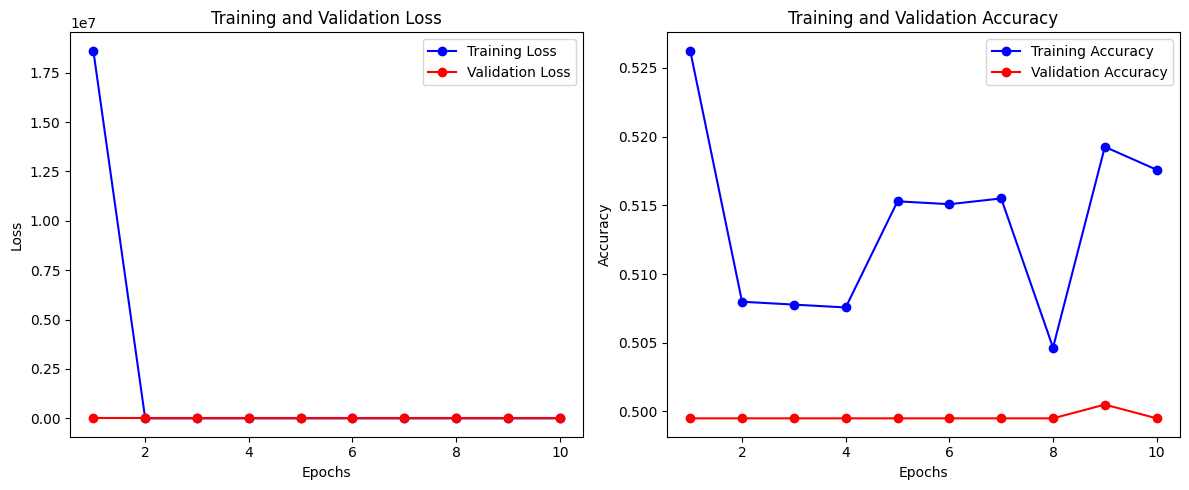

In [ ]:
# Extract the history data for accuracy and loss
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create side-by-side plots
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Confusion Matrix of RGB model


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


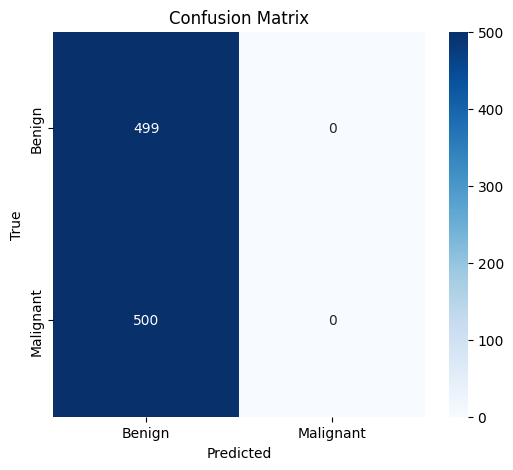

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(validation_ds_eval)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary class (0 or 1)

# True labels from validation dataset
y_true = np.concatenate([y for x, y in validation_ds_eval], axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Provides a matrix that shows the counts of correct and incorrect predictions, helping to evaluate how well your model is classifying each class.

# ROC Curve of RGB model

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


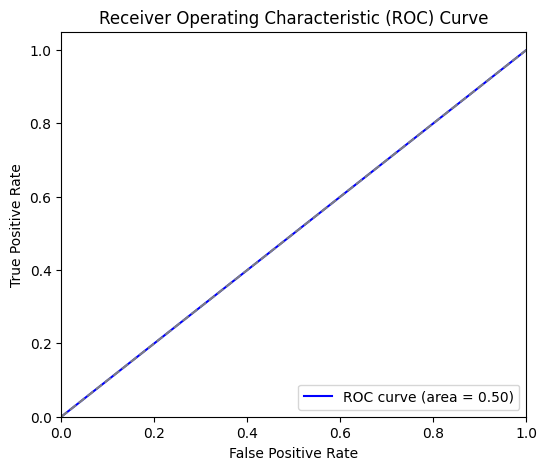

In [ ]:
# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=[0, 1])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_bin, model.predict(validation_ds_eval))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Plots the true positive rate (sensitivity) vs. the false positive rate, which helps evaluate the trade-off between sensitivity and specificity.

# Classification report of RGB model

In [ ]:
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

Classification Report:
               precision    recall  f1-score   support

      Benign       0.50      1.00      0.67       499
   Malignant       0.00      0.00      0.00       500

    accuracy                           0.50       999
   macro avg       0.25      0.50      0.33       999
weighted avg       0.25      0.50      0.33       999



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **2.Model trained on normalized and grayscaled train dataset**

# Loading and preprocessing the images from normalized and grayscaled train and test dataset

In [ ]:
#Generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/normalized_grayscale_dataset/train',
    labels="inferred",                              # Automatically infer labels based on folder names
    label_mode="int",                               # Encode labels as integers (0 and 1 for binary classification)
    color_mode="grayscale",                               # Load images in RGB format
    batch_size=32,                                  # Number of images per batch
    image_size=(150, 150)                           # Resize images to 256x256 pixels
).repeat()


validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/melanoma_cancer_dataset/test_unique',
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=32,
    image_size=(150, 150)
).repeat()

# Create a non-repeating validation dataset for evaluation and prediction
validation_ds_eval = keras.utils.image_dataset_from_directory(
    directory='/content/melanoma_cancer_dataset/test_unique',
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=32,
    image_size=(150, 150),
    shuffle=False  # Keeps order consistent
)

Found 9579 files belonging to 2 classes.
Found 999 files belonging to 2 classes.
Found 999 files belonging to 2 classes.


# Creating CNN model with 3 layers

In [ ]:
#Creating CNN Model with 3 Convolution Layer

# Initialize the Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Third Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Fourth Convolutional Layer
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Flatten the output to feed into fully connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Summary

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,399,745 (54.93 MB)

 Trainable params: 14,397,825 (54.92 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Training Model

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,steps_per_epoch=steps_per_epoch,epochs=12,validation_data=validation_ds,validation_steps=validation_steps)

Epoch 1/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.7899 - loss: 0.7373 - val_accuracy: 0.8448 - val_loss: 0.3989
Epoch 2/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.8769 - loss: 0.3187 - val_accuracy: 0.8238 - val_loss: 0.5092
Epoch 3/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8951 - loss: 0.2661 - val_accuracy: 0.8729 - val_loss: 0.3972
Epoch 4/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9171 - loss: 0.2090 - val_accuracy: 0.7237 - val_loss: 0.7129
Epoch 5/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9314 - loss: 0.1743 - val_accuracy: 0.8288 - val_loss: 0.5220
Epoch 6/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9429 - loss: 0.1477 - val_accuracy: 0.7868 - val_loss: 0.5203
Epoch 7/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9450 - loss: 0.1483 - val_accuracy: 0.8198 - val_loss: 0.5192
Epoch 8/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9638 - loss: 0.1025 - 

In [ ]:
loss, accuracy = model.evaluate(validation_ds_eval)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8094 - loss: 0.5991
Test Loss: 0.6619234085083008
Test Accuracy: 0.8178178071975708


# Visualizing the performance of the trained model

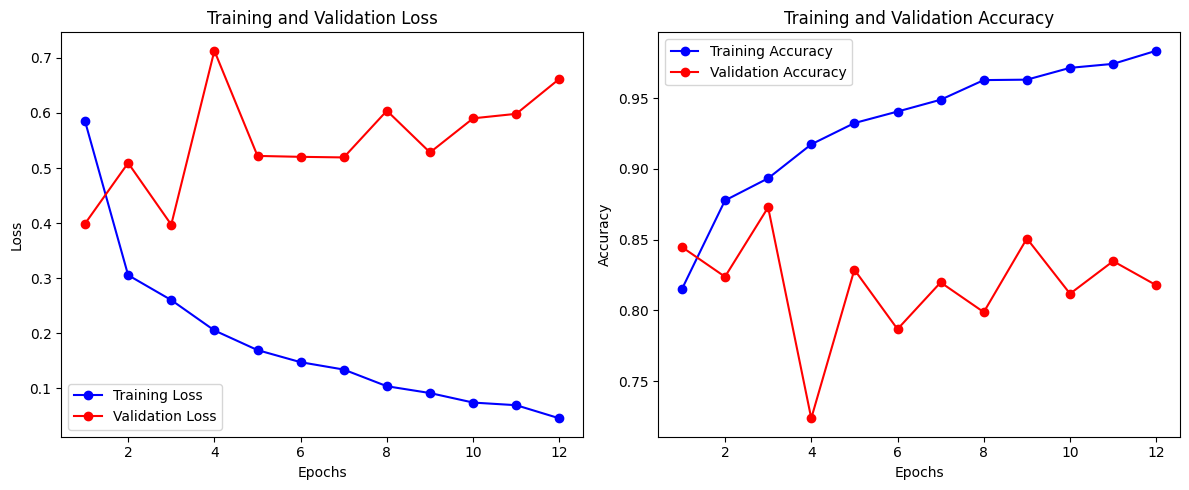

In [ ]:
# Extract the history data for accuracy and loss
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create side-by-side plots
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Confusion Matrix

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


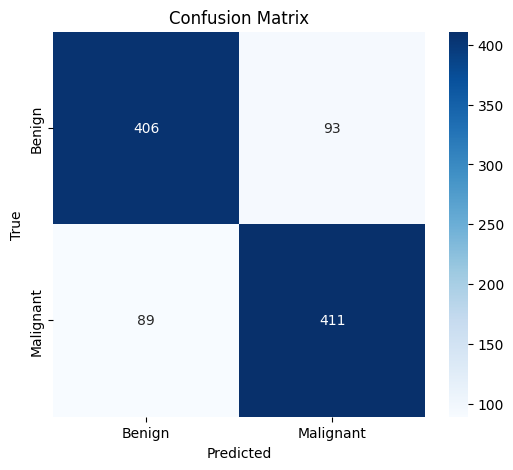

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(validation_ds_eval)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary class (0 or 1)

# True labels from validation dataset
y_true = np.concatenate([y for x, y in validation_ds_eval], axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


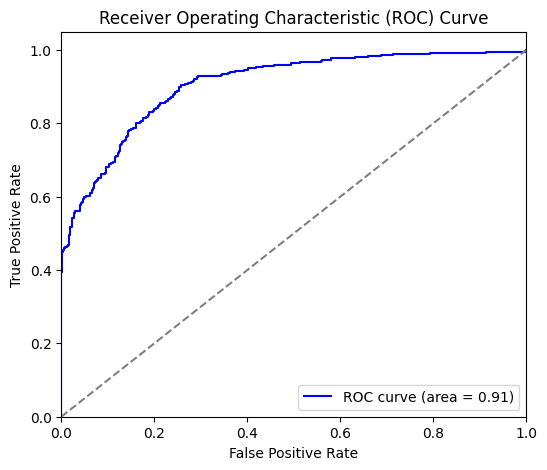

In [ ]:
# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=[0, 1])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_bin, model.predict(validation_ds_eval))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Classification Report

In [ ]:
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

Classification Report:
               precision    recall  f1-score   support

      Benign       0.82      0.81      0.82       499
   Malignant       0.82      0.82      0.82       500

    accuracy                           0.82       999
   macro avg       0.82      0.82      0.82       999
weighted avg       0.82      0.82      0.82       999



# **3.Model trained on augmented grayscale images**

# Loading and preprocessing the images from augmented train dataset and original test dataset

In [ ]:
#Generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/augmented_melanoma_cancer_dataset/train',
    labels="inferred",                              # Automatically infer labels based on folder names
    label_mode="int",                               # Encode labels as integers (0 and 1 for binary classification)
    color_mode="grayscale",                               # Load images in RGB format
    batch_size=32,                                  # Number of images per batch
    image_size=(150,150)                           # Resize images to 256x256 pixels
).repeat()


validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/melanoma_cancer_dataset/test_unique',
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=32,
    image_size=(150,150)
).repeat()

# Create a non-repeating validation dataset for evaluation and prediction
validation_ds_eval = keras.utils.image_dataset_from_directory(
    directory='/content/melanoma_cancer_dataset/test_unique',
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=32,
    image_size=(150,150),
    shuffle=False  # Keeps order consistent
)


Found 47891 files belonging to 2 classes.
Found 999 files belonging to 2 classes.
Found 999 files belonging to 2 classes.


In [ ]:
#Creating CNN Model with 3 Convolution Layer
# Initialize the Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Second Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Third Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Fourth Convolutional Layer
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Flatten the output to feed into fully connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 148, 148, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 148, 148, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 72, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 34, 34, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 15, 15, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 15, 15, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,399,745 (54.93 MB)

 Trainable params: 14,397,825 (54.92 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,steps_per_epoch=steps_per_epoch,epochs=20,validation_data=validation_ds,validation_steps=validation_steps)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.7121 - loss: 0.9759 - val_accuracy: 0.7477 - val_loss: 0.5706
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7879 - loss: 0.4705 - val_accuracy: 0.7888 - val_loss: 0.5111
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8190 - loss: 0.4043 - val_accuracy: 0.5385 - val_loss: 1.1301
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8315 - loss: 0.3783 - val_accuracy: 0.7648 - val_loss: 0.6082
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8397 - loss: 0.3733 - val_accuracy: 0.7788 - val_loss: 0.4545
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8405 - loss: 0.3528 - val_accuracy: 0.8438 - val_loss: 0.3923
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8522 - loss: 0.3406 - val_accuracy: 0.7758 - val_loss: 0.5620
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8560 - loss: 0.3392 - 

In [ ]:
loss, accuracy = model.evaluate(validation_ds_eval)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8997 - loss: 0.2874
Test Loss: 0.583247721195221
Test Accuracy: 0.7507507801055908


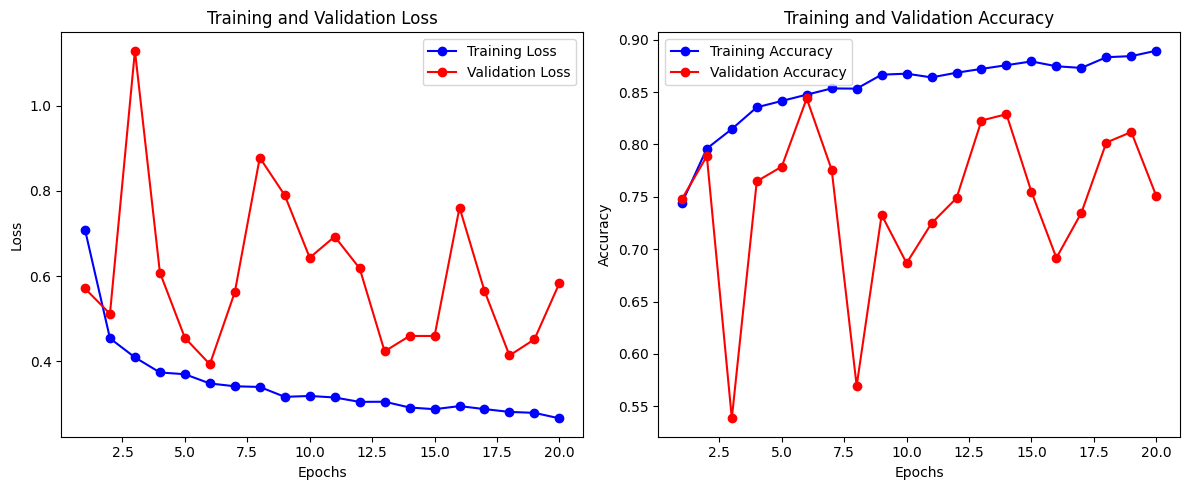

In [ ]:
# Extract the history data for accuracy and loss
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create side-by-side plots
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


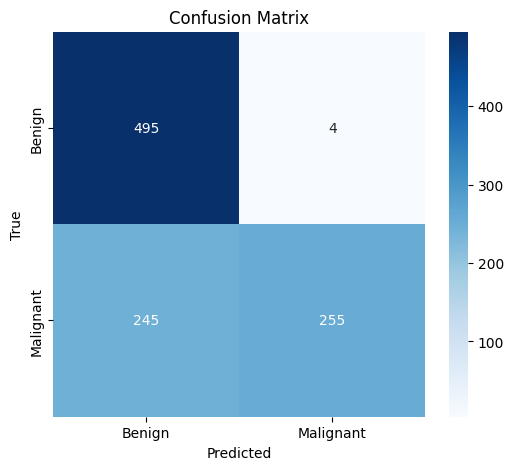

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(validation_ds_eval)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary class (0 or 1)

# True labels from validation dataset
y_true = np.concatenate([y for x, y in validation_ds_eval], axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


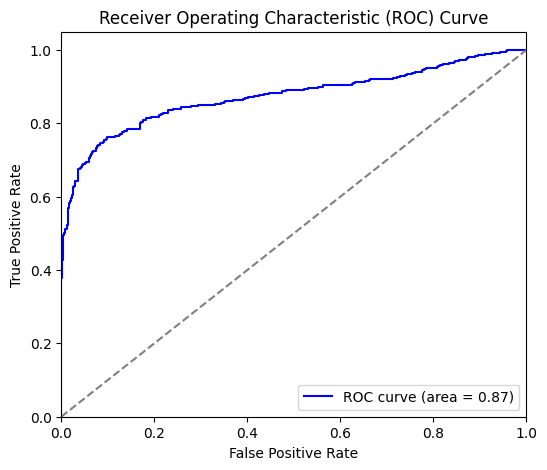

In [ ]:
# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=[0, 1])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_bin, model.predict(validation_ds_eval))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

Classification Report:
               precision    recall  f1-score   support

      Benign       0.67      0.99      0.80       499
   Malignant       0.98      0.51      0.67       500

    accuracy                           0.75       999
   macro avg       0.83      0.75      0.74       999
weighted avg       0.83      0.75      0.74       999



# **4.Model trained on augmented original preprocessed rgb image dataset**

In [ ]:
#Generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/original_augmented_melanoma_cancer_dataset/train',
    labels="inferred",                              # Automatically infer labels based on folder names
    label_mode="int",                               # Encode labels as integers (0 and 1 for binary classification)
    color_mode="rgb",                               # Load images in RGB format
    batch_size=32,                                  # Number of images per batch
    image_size=(50,50)                           # Resize images to 256x256 pixels
).repeat()


validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/melanoma_cancer_dataset/test_unique',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(50,50)
).repeat()

# Create a non-repeating validation dataset for evaluation and prediction
validation_ds_eval = keras.utils.image_dataset_from_directory(
    directory='/content/melanoma_cancer_dataset/test_unique',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(50,50),
    shuffle=False  # Keeps order consistent
)

Found 47885 files belonging to 2 classes.
Found 999 files belonging to 2 classes.
Found 999 files belonging to 2 classes.


In [ ]:
#Creating CNN Model with 3 Convolution Layer
# Initialize the Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(50,50,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Second Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Third Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Fourth Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Flatten the output to feed into fully connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 22, 22, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 9, 9, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 2, 2, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,801 (1.18 MB)

 Trainable params: 308,097 (1.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,steps_per_epoch=steps_per_epoch,epochs=19,validation_data=validation_ds,validation_steps=validation_steps)

Epoch 1/19
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7343 - loss: 0.5487 - val_accuracy: 0.8158 - val_loss: 0.4110
Epoch 2/19
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8206 - loss: 0.4070 - val_accuracy: 0.8659 - val_loss: 0.3269
Epoch 3/19
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8495 - loss: 0.3532 - val_accuracy: 0.8448 - val_loss: 0.3251
Epoch 4/19
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8584 - loss: 0.3333 - val_accuracy: 0.8258 - val_loss: 0.3589
Epoch 5/19
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8759 - loss: 0.2911 - val_accuracy: 0.8709 - val_loss: 0.3128
Epoch 6/19
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8808 - loss: 0.2807 - val_accuracy: 0.8659 - val_loss: 0.3210
Epoch 7/19
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8819 - loss: 0.2870 - val_accuracy: 0.8629 - val_loss: 0.2961
Epoch 8/19
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8853 - loss: 0.2740 - val_accura

In [ ]:
loss, accuracy = model.evaluate(validation_ds_eval)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8457 - loss: 0.3477
Test Loss: 0.2925218343734741
Test Accuracy: 0.8698698878288269


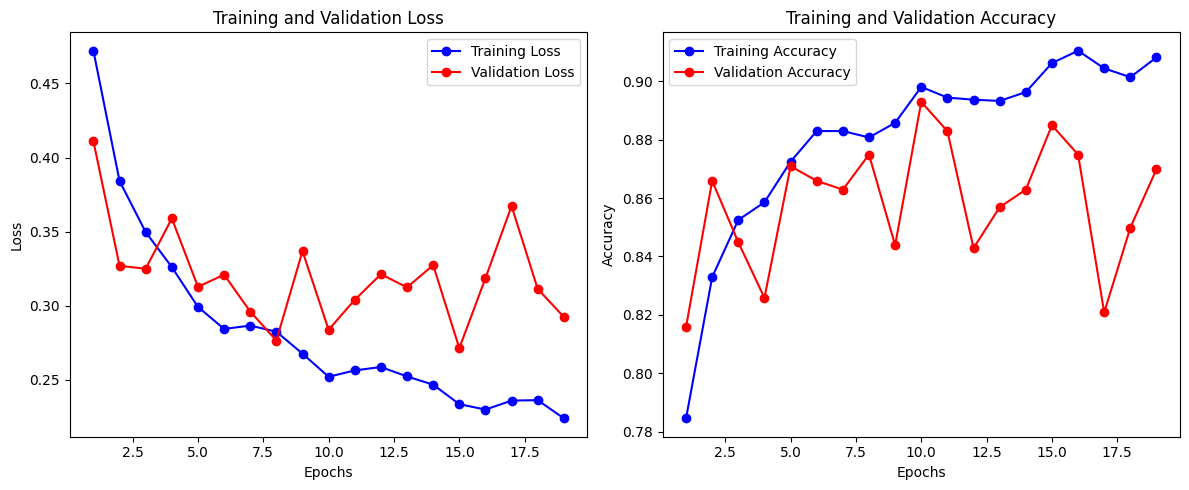

In [ ]:
# Extract the history data for accuracy and loss
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create side-by-side plots
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


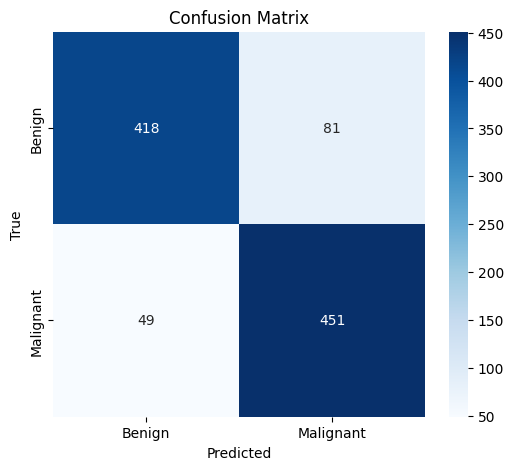

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(validation_ds_eval)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary class (0 or 1)

# True labels from validation dataset
y_true = np.concatenate([y for x, y in validation_ds_eval], axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


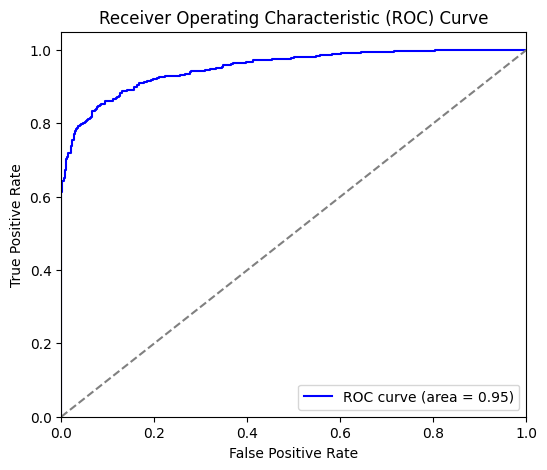

In [ ]:
# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=[0, 1])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_bin, model.predict(validation_ds_eval))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

Classification Report:
               precision    recall  f1-score   support

      Benign       0.90      0.84      0.87       499
   Malignant       0.85      0.90      0.87       500

    accuracy                           0.87       999
   macro avg       0.87      0.87      0.87       999
weighted avg       0.87      0.87      0.87       999



# **PreTrained Transfer Learning Models**

# **VGG16 Model**

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
# Paths to train and validation datasets
train_dir = "/content/original_augmented_melanoma_cancer_dataset/train"
val_dir = "/content/melanoma_cancer_dataset/test_unique"

# Image size for VGG models
img_size = (224,224)
batch_size = 16
num_classes = 2  # Binary classification (benign/malignant)

In [8]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 47885 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


In [ ]:
# Build the VGG16 model
base_model = VGG16(
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3),
    weights="imagenet",
)
base_model.trainable = False  # Freeze the base model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Train the model
print("Training VGG16 model...")
history_vgg16 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
)

Training VGG16 model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2993/2993 ━━━━━━━━━━━━━━━━━━━━ 227s 72ms/step - accuracy: 0.8111 - loss: 0.4150 - val_accuracy: 0.8749 - val_loss: 0.3102
Epoch 2/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 243s 69ms/step - accuracy: 0.8677 - loss: 0.3118 - val_accuracy: 0.8839 - val_loss: 0.2836
Epoch 3/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 262s 69ms/step - accuracy: 0.8773 - loss: 0.2870 - val_accuracy: 0.8869 - val_loss: 0.2721
Epoch 4/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 262s 69ms/step - accuracy: 0.8819 - loss: 0.2759 - val_accuracy: 0.8939 - val_loss: 0.2594
Epoch 5/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 262s 69ms/step - accuracy: 0.8915 - loss: 0.2597 - val_accuracy: 0.8929 - val_loss: 0.2547
Epoch 6/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 212s 71ms/step - accuracy: 0.8938 - loss: 0.2534 - val_accuracy: 0.8939 - val_loss: 0.2478
Epoch 7/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 258s 69ms/step - accuracy: 0.8938 - loss: 0.2518 - val_accuracy: 0.8909 - val_loss: 0.2703
Epoch 8/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 212s 71ms/step - accuracy: 0.8971 - lo

In [ ]:
# Storing Model in aother variable for future reference
model_vgg16 = model
# Evaluate the model
print("Evaluating VGG16 model...")
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f"VGG16 Accuracy: {accuracy:.4f}")

Evaluating VGG16 model...
VGG16 Accuracy: 0.8919


# Classification Report for VGG16 Model

In [ ]:
# Generate predictions for the validation set
val_predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices
true_classes = val_generator.classes  # True labels from the generator
class_labels = list(val_generator.class_indices.keys())  # Class names

# Generate and display the classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.85      0.95      0.90       499
   malignant       0.95      0.83      0.88       500

    accuracy                           0.89       999
   macro avg       0.90      0.89      0.89       999
weighted avg       0.90      0.89      0.89       999



# Confusion Matrix for VGG16 Model

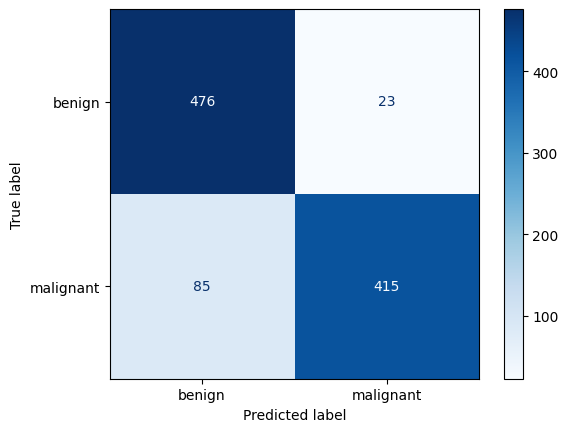

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(true_classes, predicted_classes, display_labels=class_labels, cmap="Blues")

# Loss Plot for VGG16 Model

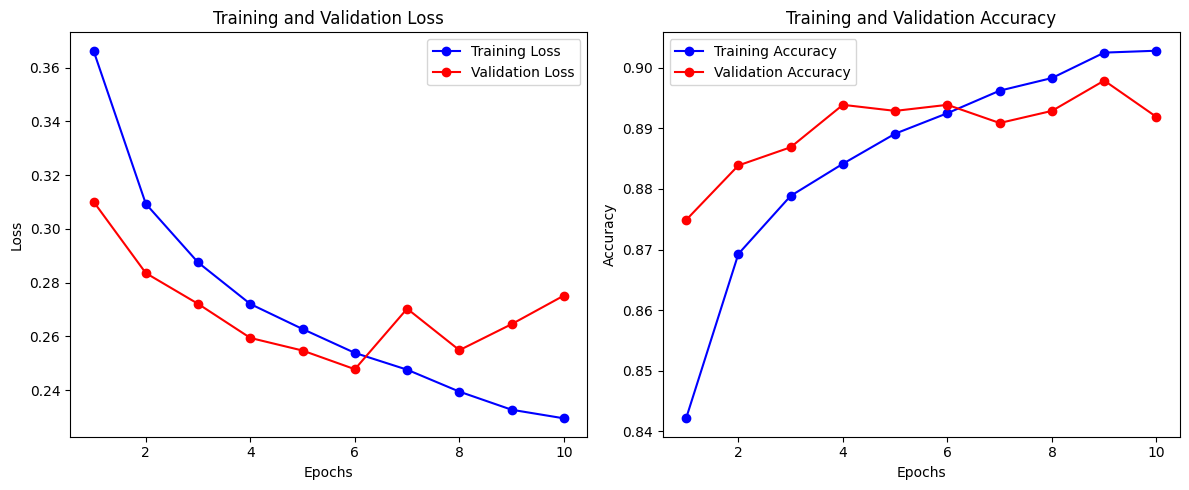

In [ ]:
# Extract the history data for accuracy and loss
history_dict = history_vgg16.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create side-by-side plots
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# **VGG19 Model**

In [9]:
# Build the VGG19 model
base_model = VGG19(
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3),
    weights="imagenet",
)
base_model.trainable = False  # Freeze the base model

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [11]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [12]:
# Train the model
print("Training VGG19 model...")
history_vgg19 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
)

Training VGG19 model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2993/2993 ━━━━━━━━━━━━━━━━━━━━ 267s 85ms/step - accuracy: 0.7535 - loss: 0.5389 - val_accuracy: 0.8198 - val_loss: 0.3923
Epoch 2/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 301s 82ms/step - accuracy: 0.8267 - loss: 0.3902 - val_accuracy: 0.8198 - val_loss: 0.4046
Epoch 3/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 244s 81ms/step - accuracy: 0.8301 - loss: 0.3757 - val_accuracy: 0.8468 - val_loss: 0.3909
Epoch 4/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 262s 81ms/step - accuracy: 0.8463 - loss: 0.3547 - val_accuracy: 0.8298 - val_loss: 0.4558
Epoch 5/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 262s 82ms/step - accuracy: 0.8526 - loss: 0.3372 - val_accuracy: 0.8569 - val_loss: 0.3553
Epoch 6/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 261s 81ms/step - accuracy: 0.8577 - loss: 0.3324 - val_accuracy: 0.8519 - val_loss: 0.3626
Epoch 7/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 262s 82ms/step - accuracy: 0.8603 - loss: 0.3241 - val_accuracy: 0.8609 - val_loss: 0.3734
Epoch 8/10
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 261s 81ms/step - accuracy: 0.8610 - lo

In [13]:
# Evaluate the model
print("Evaluating VGG19 model...")
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f"VGG19 Accuracy: {accuracy:.4f}")

Evaluating VGG19 model...
VGG19 Accuracy: 0.8549


# Classification Report for VGG19 Model

In [14]:
# Generate predictions for the validation set
val_predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices
true_classes = val_generator.classes  # True labels from the generator
class_labels = list(val_generator.class_indices.keys())  # Class names

# Generate and display the classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.85      0.86      0.86       499
   malignant       0.86      0.85      0.85       500

    accuracy                           0.85       999
   macro avg       0.85      0.85      0.85       999
weighted avg       0.85      0.85      0.85       999



# Confusion Matrix for VGG19 Model

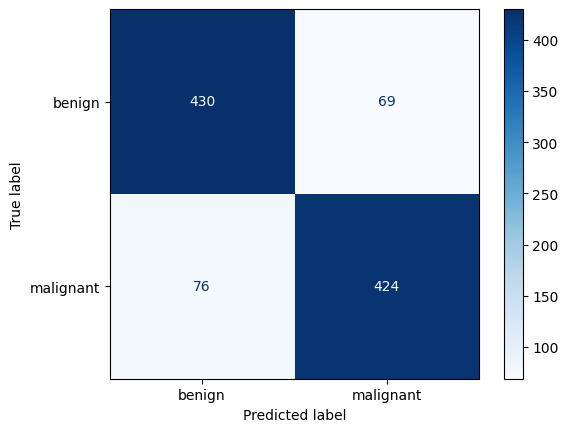

In [15]:
# Optional: Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(true_classes, predicted_classes, display_labels=class_labels, cmap="Blues")

# Loss Plot for VGG19 Model

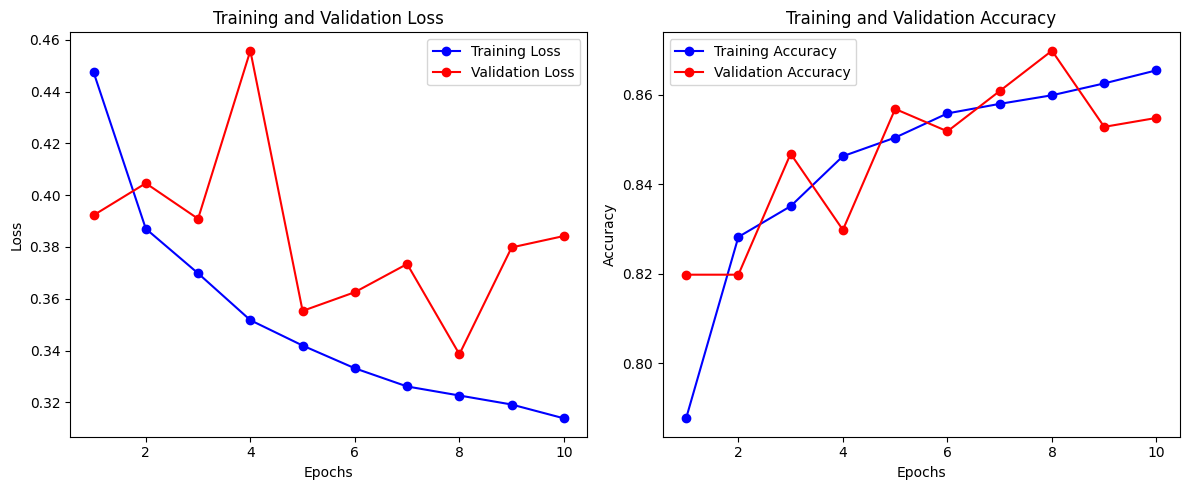

In [16]:
# Extract the history data for accuracy and loss
history_dict = history_vgg19.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create side-by-side plots
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# **Final Evaluation of Models**

# Creating the comparison table

In [17]:
# Assuming you have the val_accuracy and f1_score for benign and malignant cases
# Replace these with your actual values
model_names = ['CNN Original RGB Model', 'CNN Grayscale Normalized Model', 'CNN Grayscale Augmented Model', 'CNN Augmented Original RGB Model', 'VGG16 Model', 'VGG19 Model']  # Replace with your model names
val_accuracy=         [0.50, 0.82, 0.75, 0.87, 0.89, 0.85]  # Validation Accuracy
f1_score_benign =     [0.67, 0.82, 0.80, 0.87, 0.90, 0.86]  # F1 Score for benign
f1_score_malignant =  [0.00, 0.82, 0.67, 0.87, 0.88, 0.85]  # F1 Score for malignant

# Create a DataFrame
data = {
    'Model': model_names,
    'Accuracy': val_accuracy,
    'F1 Score (Benign)': f1_score_benign,
    'F1 Score (Malignant)': f1_score_malignant
}
df = pd.DataFrame(data)

# Style the DataFrame
styled_df = df.style.format({
    'Accuracy': '{:.2f}',
    'F1 Score (Benign)': '{:.2f}',
    'F1 Score (Malignant)': '{:.2f}'
}).background_gradient(cmap='coolwarm', subset=[
    'Accuracy',
    'F1 Score (Benign)',
    'F1 Score (Malignant)'
]).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#4CAF50'), ('color', 'white'), ('font-size', '16px')]},  # Increased font size for heading
    {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '14px')]},  # Increased font size for table cells
    {'selector': 'caption', 'props': [('font-size', '20px'), ('font-weight', 'bold'), ('text-align', 'center')]},  # Increased font size for caption
])

# Set the caption separately
styled_df.set_caption('Comparison of Models')

styled_df


Out of all the available model the accuracy and F1 score for both classes is high for the VGG16 model hence saving this model for further use in developing a skin cancer detection application. Moreover using VGG16 model will beneficial as it will be able to classify the images more accuractely than other models.

# **Classification Report of VGG16 Model**

In [ ]:
# Generate predictions for the validation set
val_predictions = model_vgg16.predict(val_generator, verbose=1)
predicted_classes = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices
true_classes = val_generator.classes  # True labels from the generator
class_labels = list(val_generator.class_indices.keys())  # Class names

# Generate and display the classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.85      0.95      0.90       499
   malignant       0.95      0.83      0.88       500

    accuracy                           0.89       999
   macro avg       0.90      0.89      0.89       999
weighted avg       0.90      0.89      0.89       999



# **Confusion Matrix of VGG16 Model**

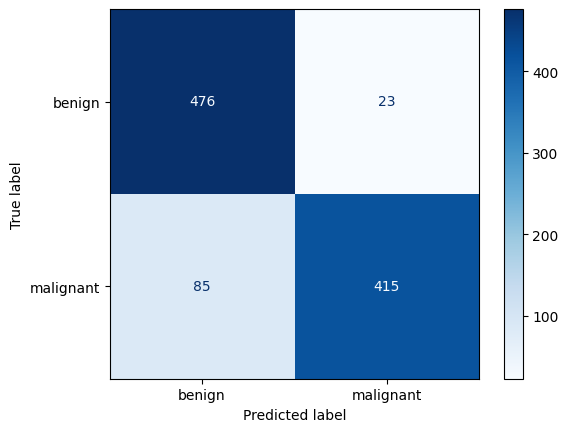

In [ ]:
# Optional: Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(true_classes, predicted_classes, display_labels=class_labels, cmap="Blues")

# **Loss Plot for VGG16 Model**

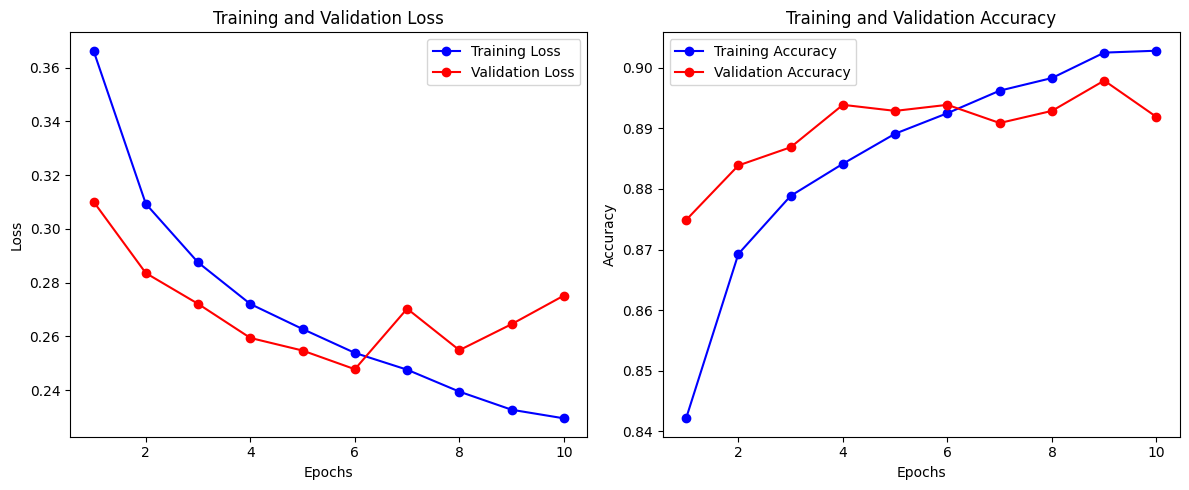

In [ ]:
# Extract the history data for accuracy and loss
history_dict = history_vgg16.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create side-by-side plots
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# **Saving the VGG16 Model**

In [ ]:
model_vgg16.save('vgg16_model.keras')

# **Downloading the VGG16 Model**

In [ ]:
files.download('vgg16_model.keras')



---






# **THANK YOU**